In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal as sig
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import pandas as pd
from prettytable import PrettyTable

In [2]:
plt.rcParams['figure.figsize'] = (12,6)

In [3]:
def process(df):
    df.drop(['TIME  AXIS    - Plot 0',
           'TIME  AXIS    - Plot 1',
           'TIME  AXIS    - Plot 2',
           'TIME  AXIS    - Plot 3',
           'TIME  AXIS    - Plot 4',
           'TIME  AXIS    - Plot 5'],axis=1,inplace=True)
    
    df.dropna(inplace=True)

In [64]:
def autoscales(N, dt, dj, wf='morlet', p=6):
    """Compute scales as fractional power of two."""
    if wf == 'dog':
        s0 = (dt * np.sqrt(p + 0.5)) / np.pi
    elif wf == 'paul':
        s0 = (dt * ((2 * p) + 1)) / (2 * np.pi)
    elif wf == 'morlet':
        s0 = (dt * (p + np.sqrt(2 + p ** 2))) / (2 * np.pi)
    else:
        raise ValueError('wavelet function not available')

    J = int(np.floor(dj ** -1 * np.log2((N * dt) / s0)))
    s = np.empty(J + 1)

    for i in range(s.shape[0]):
        s[i] = s0 * 2 ** (i * dj)

    return s

def smooth_and_find_peaks(signal):
    smoothed_signal = sig.savgol_filter(signal, 51, 2)
    peaks, _ = find_peaks(smoothed_signal)
    return smoothed_signal, peaks

def plot_signal_with_peaks(ax, t, ns_signal, sm_signal, peaks, title):
    ax.plot(t, ns_signal, 'navy', label='noisy')
    ax.plot(t, sm_signal, 'firebrick', label='smooth')
    ax.plot(t[peaks], sm_signal[peaks], 'ro')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.legend()

def plot_spectrogram(ax, signal, title):
    # Spectrogram
    freq, time, sxx = sig.spectrogram(signal)
    plot = ax.contourf(time, freq, np.log10(sxx), cmap='jet', aspect='auto')
    ax.set_title(f'Spectrogram of {title}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time')
    plt.colorbar(plot, ax=ax)

def plot_cwt(ax,signal,title):
    # Continuous Wavelet Transform
    wavelet = 'morl'  # Complex Morlet wavelet
    widths = autoscales(len(signal), 1, 0.6)
    cwmatr, freq_cwt = pywt.cwt(signal, widths, wavelet)
    cwtmatr = np.abs(cwmatr)**2
    plot = ax.imshow(cwtmatr, cmap='jet', aspect='auto', extent=[0, 1, min(widths), max(widths)])
    ax.set_title(f'CWT of {title}')
    ax.set_ylabel('Scales')
    ax.set_xlabel('Time')
    plt.colorbar(plot, ax=ax)

def calculate_power_density_spectrum(signal, fs=1000):
    freq, psd = sig.welch(signal, fs, nperseg=1024)
    return freq, psd

def calculate_temporal_features(signal, fs):
    mean_amp = np.mean(signal)
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return mean_amp, std_dev, skewness, kurt

def calculate_spectral_features(freq, power_spectral_density):
    max_freq = freq[np.argmax(power_spectral_density)]
    total_power = np.sum(power_spectral_density)
    normalized_power = power_spectral_density / total_power
    spectral_centroid = np.sum(normalized_power * freq)
    spectral_spread = np.sqrt(np.sum(normalized_power * (freq - spectral_centroid)**2))
    return max_freq, spectral_centroid, spectral_spread

# def calculate_vector_strength(peaks, t):
#     # Calculate angular phases from peak times
#     phases = 2 * np.pi * t[peaks]

#     # Calculate mean resultant vector
#     mean_resultant_vector = np.mean(np.exp(1j * phases))

#     # Calculate vector strength
#     vector_strength = np.abs(mean_resultant_vector)

#     return vector_strength

def analyze_and_plot_signals(ns_signals,sig_names, t, fs=1000):
    num_signals = len(ns_signals)

    # Create subplots
    fig, axs = plt.subplots(4, num_signals, figsize=(20, 15))
    axs = axs.flatten()

    # Create tables for numerical values
    columns_temporal = ['Signal', 'Mean Amplitude', 'Std Deviation', 'Skewness', 'Kurtosis']
    columns_spectral = ['Signal', 'Max Frequency', 'Spectral Centroid', 'Spectral Spread']
#     columns_vector_strength = ['Signal', 'Vector Strength']

    table_temporal = PrettyTable(columns_temporal)
    table_spectral = PrettyTable(columns_spectral)
#     table_vector_strength = PrettyTable(columns_vector_strength)


    for i, ns_signal in enumerate(ns_signals, start=1):
        
        sm_signal, peaks = smooth_and_find_peaks(ns_signal)

        # Plot the signals with detected peaks
        plot_signal_with_peaks(axs[i - 1], t, ns_signal, sm_signal, peaks, f'Smoothed  {sig_names[i-1]}')

        # Plot CWT and Spectrogram
        plot_spectrogram(axs[i + num_signals - 1], sm_signal, f' {sig_names[i-1]}')
        plot_cwt(axs[i + 2 * num_signals - 1], sm_signal, f' {sig_names[i-1]}')
        # Calculate and plot Power Density Spectrum
        freq_psd, psd = calculate_power_density_spectrum(sm_signal, fs)
        plt.ylim(0.5e-9,0)
        axs[i + 3 * num_signals - 1].semilogy(freq_psd, psd)
        axs[i + 3 * num_signals - 1].set_title(f'Power Spectral Density ({sig_names[i-1]})')
        axs[i + 3 * num_signals - 1].set_xlabel('Frequency (Hz)')
        axs[i + 3 * num_signals - 1].set_ylabel('Power/Frequency (dB/Hz)')

        # Calculate and print Temporal Features
        temporal_features = calculate_temporal_features(sm_signal, fs)
        temporal_features = [round(value, 6) for value in temporal_features]

        # Calculate and print Spectral Features
        spectral_features = calculate_spectral_features(freq_psd, psd)
        spectral_features = [round(value, 6) for value in spectral_features]

        # Calculate and print Vector Strength
#         vector_strength = calculate_vector_strength(peaks, t)
#         vector_strength = round(vector_strength, 6)
        
        # Add data to PrettyTable
        # Add data to PrettyTables
        table_temporal.add_row([f' {sig_names[i-1]}'] + temporal_features)
        table_spectral.add_row([f'{sig_names[i-1]}'] + spectral_features)
#         table_vector_strength.add_row([f' {sig_names[i]}', vector_strength])
        
    plt.tight_layout()
    plt.show()
    
    # Print PrettyTables
    print("Temporal Features:")
    print(table_temporal)

    print("\nSpectral Features:")
    print(table_spectral)

#     print("\nVector Strength:")
#     print(table_vector_strength)

# High Aerated Slug

In [5]:
HAS_5_600 = pd.read_excel('../../data/pressure raw/HAS/5/600/run1.xlsx')

In [6]:
HAS_5_600

TIME  AXIS    - Plot 0  \
0           1005686:09:38.860   
1           1005686:09:38.861   
2           1005686:09:38.862   
3           1005686:09:38.863   
4           1005686:09:38.864   
...                       ...   
203000                    NaN   
203001                    NaN   
203002                    NaN   
203003                    NaN   
203004                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 0  \
0                                                0.066020     
1                                                0.063330     
2                                                0.062110     
3                                                0.064310     
4                                                0.068950     
...                                                   ...     
203000                                           0.061544     
203001                                                NaN     
203002                                                NaN     
203003                                                NaN     
203004                                                NaN     

       TIME  AXIS    - Plot 1  \
0           1005686:09:38.860   
1           1005686:09:38.861   
2           1005686:09:38.862   
3           1005686:09:38.863   
4           1005686:09:38.864   
...                       ...   
203000                    NaN   
203001                    NaN   
203002                    NaN   
203003                    NaN   
203004                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 1  \
0                                                0.026710     
1                                                0.024020     
2                                                0.016460     
3                                                0.021090     
4                                                0.021090     
...                                                   ...     
203000                                           0.041463     
203001                                                NaN     
203002                                                NaN     
203003                                                NaN     
203004                                                NaN     

       TIME  AXIS    - Plot 2  \
0           1005686:09:38.860   
1           1005686:09:38.861   
2           1005686:09:38.862   
3           1005686:09:38.863   
4           1005686:09:38.864   
...                       ...   
203000                    NaN   
203001                    NaN   
203002                    NaN   
203003                    NaN   
203004                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 2  \
0                                                0.021090     
1                                                0.019380     
2                                                0.022800     
3                                                0.018900     
4                                                0.017190     
...                                                   ...     
203000                                           0.038721     
203001                                                NaN     
203002                                                NaN     
203003                                                NaN     
203004                                                NaN     

       TIME  AXIS    - Plot 3  \
0           1005686:09:38.860   
1           1005686:09:38.861   
2           1005686:09:38.862   
3           1005686:09:38.863   
4           1005686:09:38.864   
...                       ...   
203000                    NaN   
203001                    NaN   
203002                    NaN   
203003                    NaN   
203004                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 3  \
0                                                0.020610     
1                     

In [7]:
process(HAS_5_600)

In [8]:
HAS_5_600_sen4 = HAS_5_600['PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 4'][:60000]

In [9]:
time = HAS_5_600_sen4.index[:60000]

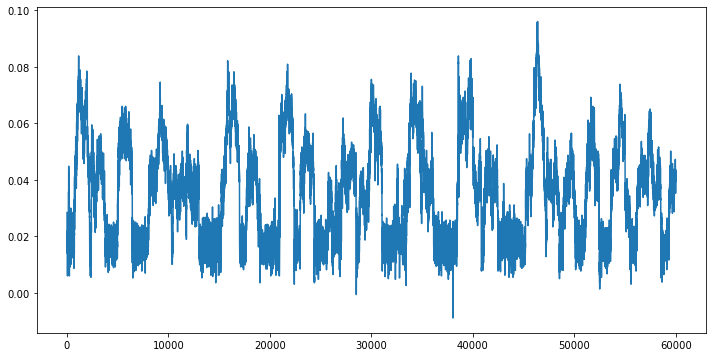

In [10]:
plt.plot(time,HAS_5_600_sen4);

In [12]:
HAS_5_600_sen4_sm = sig.savgol_filter(HAS_5_600_sen4,51,2)

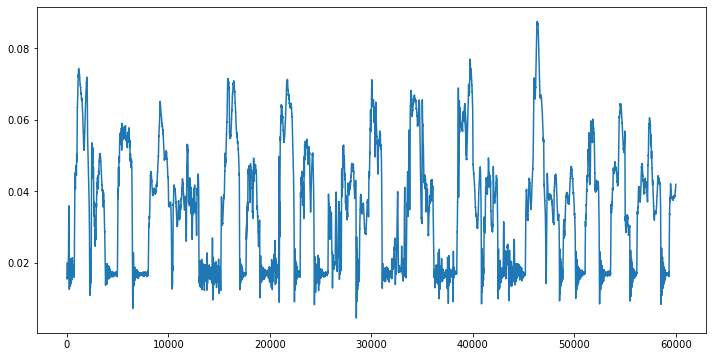

In [13]:
plt.plot(time,HAS_5_600_sen4_sm);

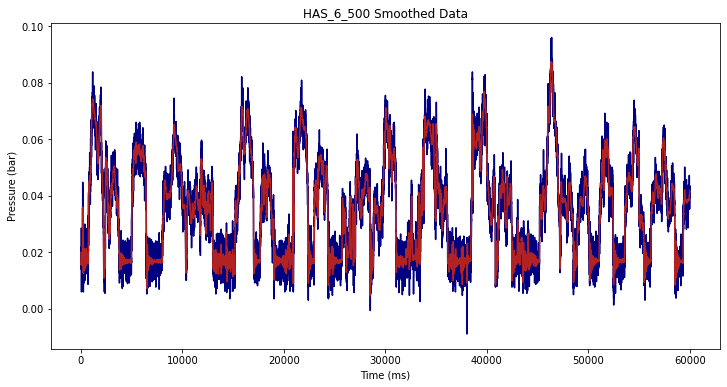

In [14]:
plt.plot(time,HAS_5_600_sen4,'navy')
plt.plot(time,HAS_5_600_sen4_sm,'firebrick')
plt.xlabel('Time (ms)')
plt.ylabel('Pressure (bar)')
plt.title('HAS_6_500 Smoothed Data')
plt.show()

In [15]:
def autoscales(N, dt, dj, wf='morlet', p=6):
    """Compute scales as fractional power of two.

     :Parameters:
        N : integer
           number of data samples
        dt : float
           time step
        dj : float
           scale resolution (smaller values of dj give finer resolution)
        wf : string
           wavelet function ('morlet', 'paul', 'dog')
        p : float
           omega0 ('morlet') or order ('paul', 'dog')

     :Returns:
        scales : 1d numpy array
           scales
     """

    if wf == 'dog':
        s0 = (dt * sqrt(p + 0.5)) / np.pi
    elif wf == 'paul':
        s0 = (dt * ((2 * p) + 1)) / (2 * np.pi)
    elif wf == 'morlet':
        s0 = (dt * (p + np.sqrt(2 + p ** 2))) / (2 * np.pi)
    else:
        raise ValueError('wavelet function not available')

    #  See (9) and (10) at page 67.

    J = int(np.floor(dj ** -1 * np.log2((N * dt) / s0)))
    s = np.empty(J + 1)

    for i in range(s.shape[0]):
        s[i] = s0 * 2 ** (i * dj)

    return s

In [16]:
widths = autoscales(len(HAS_5_600_sen4_sm),1,0.6)
print(widths)

[1.93602662e+00 2.93446762e+00 4.44782118e+00 6.74163625e+00
 1.02184098e+01 1.54882129e+01 2.34757409e+01 3.55825695e+01
 5.39330900e+01 8.17472780e+01 1.23905704e+02 1.87805928e+02
 2.84660556e+02 4.31464720e+02 6.53978224e+02 9.91245629e+02
 1.50244742e+03 2.27728445e+03 3.45171776e+03 5.23182579e+03
 7.92996503e+03 1.20195794e+04 1.82182756e+04 2.76137421e+04
 4.18546064e+04]


In [17]:
cwtmatr1, freqs1 = pywt.cwt(HAS_5_600_sen4_sm,widths,'morl')

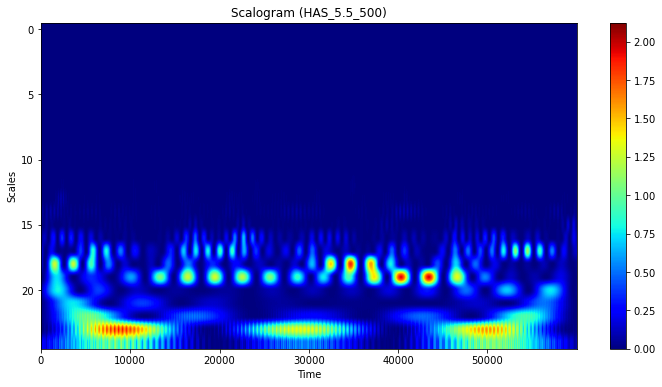

In [18]:
plt.imshow(np.abs(cwtmatr1)**2, cmap='jet',aspect='auto')
plt.colorbar()
plt.title('Scalogram (HAS_5.5_500)')
plt.xlabel('Time')
plt.ylabel('Scales')
plt.show()

In [ ]:
np.arange(cwtmatr1.shape[0])

In [ ]:
np.arange(cwtmatr1.shape[1])

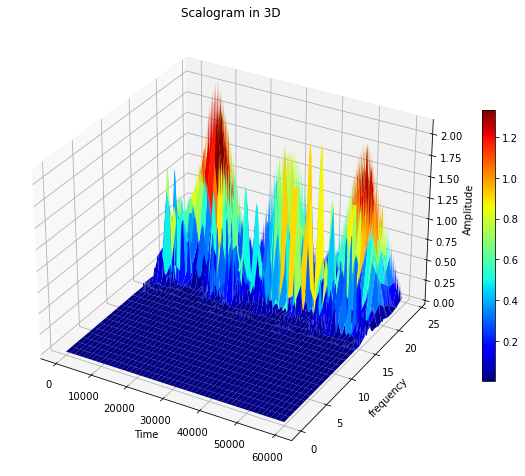

In [19]:
# Plotting Scalogram in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(cwtmatr1.shape[1]),np.arange(cwtmatr1.shape[0]))
sur=ax.plot_surface(X, Y, np.abs(cwtmatr1)**2, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('frequency')
ax.set_zlabel('Amplitude')
ax.set_title('Scalogram in 3D')
plt.colorbar(sur,shrink=0.5)
plt.show()


## Low Aerated Slug

In [20]:
LAS_3_600 = pd.read_excel('../../data/pressure raw/LAS/3/600/run1.xlsx')

In [21]:
LAS_3_600

TIME  AXIS    - Plot 0  \
0           1005584:38:02.300   
1           1005584:38:02.301   
2           1005584:38:02.302   
3           1005584:38:02.303   
4           1005584:38:02.304   
...                       ...   
206999      1005584:42:05.487   
207000                    NaN   
207001                    NaN   
207002                    NaN   
207003                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 0  \
0                                                0.055270     
1                                                0.054790     
2                                                0.055030     
3                                                0.055760     
4                                                0.057230     
...                                                   ...     
206999                                           0.030620     
207000                                           0.046568     
207001                                                NaN     
207002                                                NaN     
207003                                                NaN     

       TIME  AXIS    - Plot 1  \
0           1005584:38:02.300   
1           1005584:38:02.301   
2           1005584:38:02.302   
3           1005584:38:02.303   
4           1005584:38:02.304   
...                       ...   
206999      1005584:42:05.487   
207000                    NaN   
207001                    NaN   
207002                    NaN   
207003                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 1  \
0                                                0.034030     
1                                                0.034030     
2                                                0.034030     
3                                                0.034030     
4                                                0.033300     
...                                                   ...     
206999                                           0.026950     
207000                                           0.033184     
207001                                                NaN     
207002                                                NaN     
207003                                                NaN     

       TIME  AXIS    - Plot 2  \
0           1005584:38:02.300   
1           1005584:38:02.301   
2           1005584:38:02.302   
3           1005584:38:02.303   
4           1005584:38:02.304   
...                       ...   
206999      1005584:42:05.487   
207000                    NaN   
207001                    NaN   
207002                    NaN   
207003                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 2  \
0                                                0.033540     
1                                                0.032810     
2                                                0.033060     
3                                                0.032810     
4                                                0.033300     
...                                                   ...     
206999                                           0.025730     
207000                                           0.031226     
207001                                                NaN     
207002                                                NaN     
207003                                                NaN     

       TIME  AXIS    - Plot 3  \
0           1005584:38:02.300   
1           1005584:38:02.301   
2           1005584:38:02.302   
3           1005584:38:02.303   
4           1005584:38:02.304   
...                       ...   
206999      1005584:42:05.487   
207000                    NaN   
207001                    NaN   
207002                    NaN   
207003                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 3  \
0                                                0.032810     
1                     

In [22]:
process(LAS_3_600)

In [23]:
time = LAS_3_600.index[:60000]

In [24]:
LAS_3_600_sen4 = LAS_3_600['PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 4'][:60000]

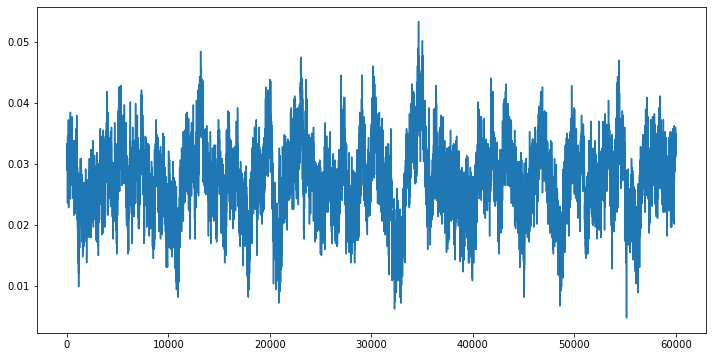

In [25]:
plt.plot(time, LAS_3_600_sen4);

In [27]:
LAS_3_600_sen4_sm = sig.savgol_filter(LAS_3_600_sen4,51,2)

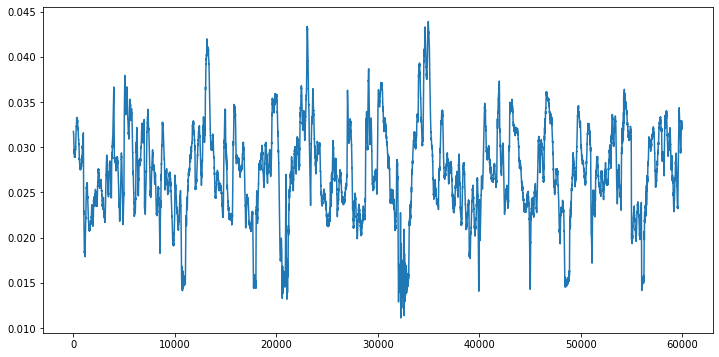

In [28]:
plt.plot(time,LAS_3_600_sen4_sm);

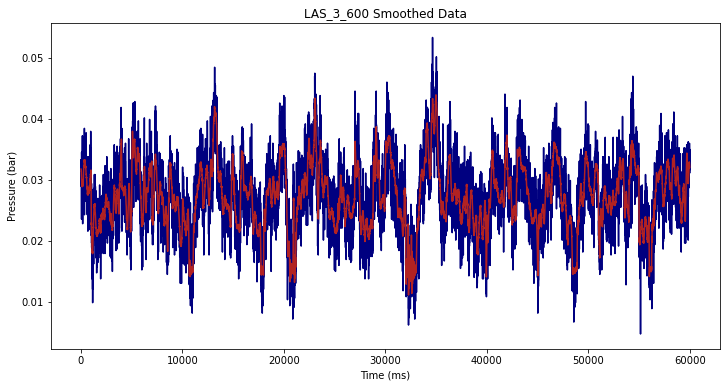

In [29]:
plt.plot(time,LAS_3_600_sen4,'navy')
plt.plot(time,LAS_3_600_sen4_sm,'firebrick')
plt.xlabel('Time (ms)')
plt.ylabel('Pressure (bar)')
plt.title('LAS_3_600 Smoothed Data')
plt.show()

In [30]:
widths = autoscales(len(LAS_3_600_sen4_sm),1,0.6)
print(widths)

[1.93602662e+00 2.93446762e+00 4.44782118e+00 6.74163625e+00
 1.02184098e+01 1.54882129e+01 2.34757409e+01 3.55825695e+01
 5.39330900e+01 8.17472780e+01 1.23905704e+02 1.87805928e+02
 2.84660556e+02 4.31464720e+02 6.53978224e+02 9.91245629e+02
 1.50244742e+03 2.27728445e+03 3.45171776e+03 5.23182579e+03
 7.92996503e+03 1.20195794e+04 1.82182756e+04 2.76137421e+04
 4.18546064e+04]


In [31]:
cwtmatr2, freqs2 = pywt.cwt(LAS_3_600_sen4_sm,widths,'morl')

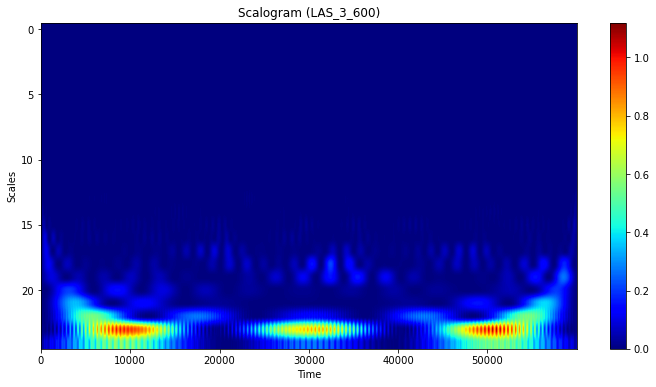

In [32]:
plt.imshow(np.abs(cwtmatr2)**2, cmap='jet',aspect='auto')
plt.colorbar()
plt.title('Scalogram (LAS_3_600)')
plt.xlabel('Time')
plt.ylabel('Scales')
plt.show()

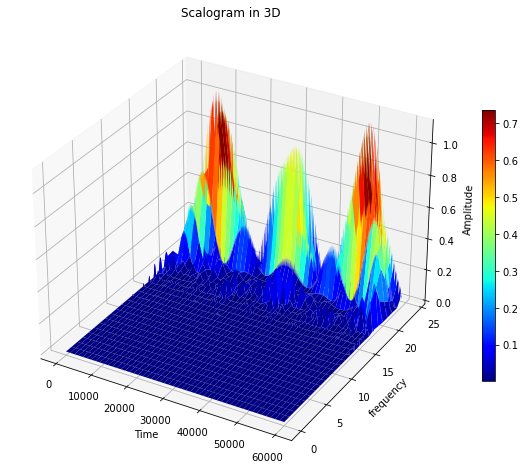

In [33]:
# Plotting Scalogram in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(cwtmatr2.shape[1]),np.arange(cwtmatr2.shape[0]))
sur= ax.plot_surface(X, Y, np.abs(cwtmatr2)**2, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('frequency')
ax.set_zlabel('Amplitude')
ax.set_title('Scalogram in 3D')
plt.colorbar(sur,shrink=0.5)
plt.show()


## Plug

In [35]:
Plug_1_600 = pd.read_excel('../../data/pressure raw/Plug/1/600/run1.xlsx')

In [36]:
Plug_1_600

TIME  AXIS    - Plot 0  \
0           1005509:21:20.771   
1           1005509:21:20.772   
2           1005509:21:20.773   
3           1005509:21:20.774   
4           1005509:21:20.775   
...                       ...   
173000                    NaN   
173001                    NaN   
173002                    NaN   
173003                    NaN   
173004                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 0  \
0                                                0.031350     
1                                                0.031590     
2                                                0.030860     
3                                                0.030860     
4                                                0.031350     
...                                                   ...     
173000                                           0.030876     
173001                                                NaN     
173002                                                NaN     
173003                                                NaN     
173004                                                NaN     

       TIME  AXIS    - Plot 1  \
0           1005509:21:20.771   
1           1005509:21:20.772   
2           1005509:21:20.773   
3           1005509:21:20.774   
4           1005509:21:20.775   
...                       ...   
173000                    NaN   
173001                    NaN   
173002                    NaN   
173003                    NaN   
173004                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 1  \
0                                                0.024020     
1                                                0.025240     
2                                                0.025730     
3                                                0.025240     
4                                                0.025000     
...                                                   ...     
173000                                           0.024942     
173001                                                NaN     
173002                                                NaN     
173003                                                NaN     
173004                                                NaN     

       TIME  AXIS    - Plot 2  \
0           1005509:21:20.771   
1           1005509:21:20.772   
2           1005509:21:20.773   
3           1005509:21:20.774   
4           1005509:21:20.775   
...                       ...   
173000                    NaN   
173001                    NaN   
173002                    NaN   
173003                    NaN   
173004                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 2  \
0                                                0.023780     
1                                                0.023540     
2                                                0.023780     
3                                                0.023540     
4                                                0.024270     
...                                                   ...     
173000                                           0.023778     
173001                                                NaN     
173002                                                NaN     
173003                                                NaN     
173004                                                NaN     

       TIME  AXIS    - Plot 3  \
0           1005509:21:20.771   
1           1005509:21:20.772   
2           1005509:21:20.773   
3           1005509:21:20.774   
4           1005509:21:20.775   
...                       ...   
173000                    NaN   
173001                    NaN   
173002                    NaN   
173003                    NaN   
173004                    NaN   

        PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 3  \
0                                                0.020120     
1                     

In [37]:
time = Plug_1_600.index[:60000]

In [38]:
Plug_1_600_sen4 = Plug_1_600['PRESSURE    AXIS    RANGE  0- 0.1 BAR      - Plot 4'][:60000]

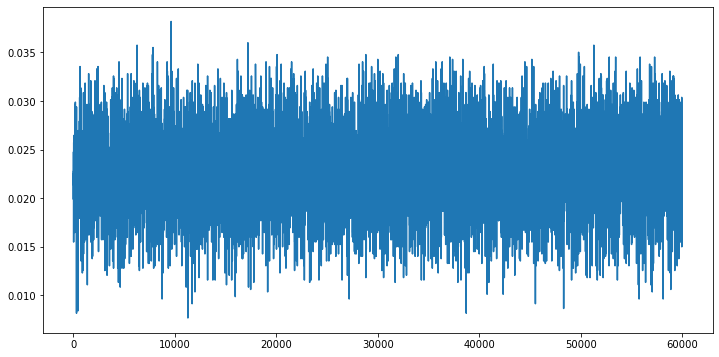

In [39]:
plt.plot(time,Plug_1_600_sen4);

In [40]:
Plug_1_600_sen4_sm = sig.savgol_filter(Plug_1_600_sen4,51,2)

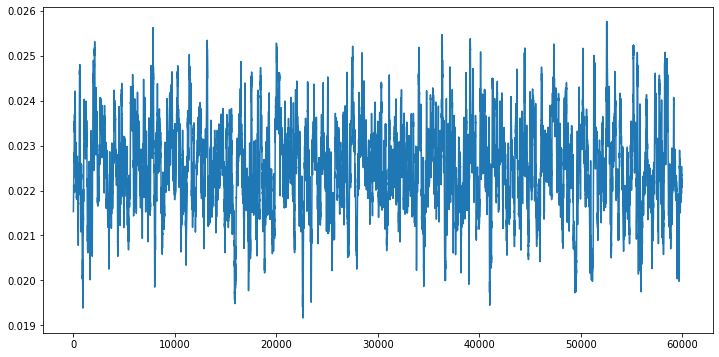

In [41]:
plt.plot(time,Plug_1_600_sen4_sm);

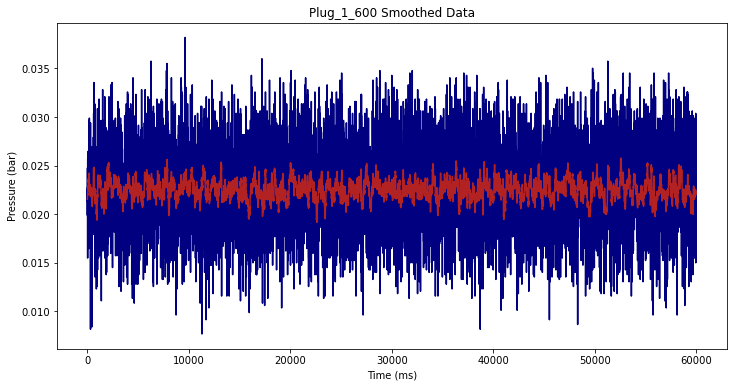

In [42]:
plt.plot(time,Plug_1_600_sen4,'navy')
plt.plot(time,Plug_1_600_sen4_sm,'firebrick')
plt.xlabel('Time (ms)')
plt.ylabel('Pressure (bar)')
plt.title('Plug_1_600 Smoothed Data')
plt.show()

In [43]:
widths = autoscales(len(Plug_1_600_sen4_sm),1,0.6)
print(widths)

[1.93602662e+00 2.93446762e+00 4.44782118e+00 6.74163625e+00
 1.02184098e+01 1.54882129e+01 2.34757409e+01 3.55825695e+01
 5.39330900e+01 8.17472780e+01 1.23905704e+02 1.87805928e+02
 2.84660556e+02 4.31464720e+02 6.53978224e+02 9.91245629e+02
 1.50244742e+03 2.27728445e+03 3.45171776e+03 5.23182579e+03
 7.92996503e+03 1.20195794e+04 1.82182756e+04 2.76137421e+04
 4.18546064e+04]


In [44]:
cwtmatr3, freqs3 = pywt.cwt(Plug_1_600_sen4_sm,widths,'morl')

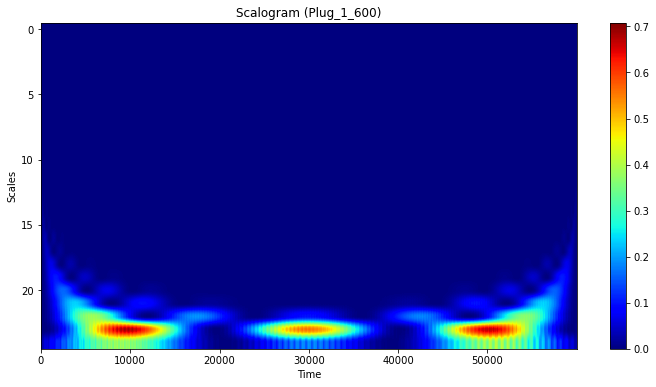

In [45]:
plt.imshow(np.abs(cwtmatr3)**2, cmap='jet',aspect='auto');

plt.colorbar()
plt.title('Scalogram (Plug_1_600)')
plt.xlabel('Time')
plt.ylabel('Scales')
plt.show()

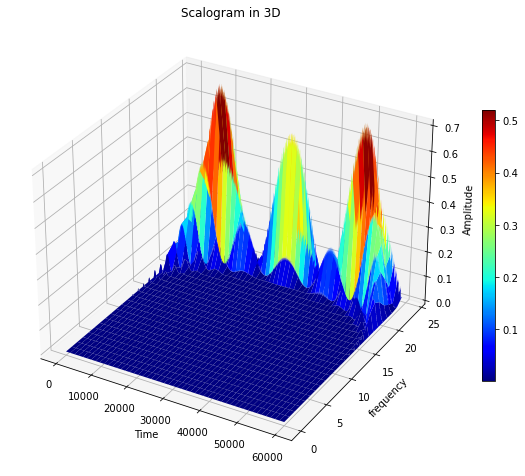

In [46]:
# Plotting Scalogram in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(cwtmatr3.shape[1]),np.arange(cwtmatr3.shape[0]))
sur = ax.plot_surface(X, Y, np.abs(cwtmatr3)**2, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('frequency')
ax.set_zlabel('Amplitude')
ax.set_title('Scalogram in 3D')
plt.colorbar(sur, shrink =0.5)
plt.show()


In [50]:
import warnings
warnings.filterwarnings("ignore")

ValueError: math domain error

ValueError: math domain error

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal as sig
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from mpl_toolkits.mplot3d import Axes3D
from prettytable import PrettyTable

plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams.update({'font.size': 32})

def autoscales(N, dt, dj, wf='morlet', p=6):
    """Compute scales as fractional power of two."""
    if wf == 'dog':
        s0 = (dt * np.sqrt(p + 0.5)) / np.pi
    elif wf == 'paul':
        s0 = (dt * ((2 * p) + 1)) / (2 * np.pi)
    elif wf == 'morlet':
        s0 = (dt * (p + np.sqrt(2 + p ** 2))) / (2 * np.pi)
    else:
        raise ValueError('wavelet function not available')

    J = int(np.floor(dj ** -1 * np.log2((N * dt) / s0)))
    s = np.empty(J + 1)

    for i in range(s.shape[0]):
        s[i] = s0 * 2 ** (i * dj)

    return s

def smooth_and_find_peaks(signal):
    smoothed_signal = sig.savgol_filter(signal, 51, 2)
    peaks, _ = find_peaks(smoothed_signal)
    return smoothed_signal, peaks

def plot_signal(ax, t, signal, title):
    ax.plot(t, signal, label=title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Pressure (bar)')
    ax.legend()
def plot_original_and_smoothed(t, ns_signal, sm_signal, title):
#     plt.figure(figsize=(10, 5))
    plt.plot(t, ns_signal, label='Original', alpha=0.5)
    plt.plot(t, sm_signal, label='Smoothed', alpha=1)
#     plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Pressure (bar)')
    plt.legend()
    plt.show()
def plot_smoothed_signal(ax, t, ns_signal, sm_signal, peaks, title):
    ax.plot(t, ns_signal, 'navy', label='noisy')
    ax.plot(t, sm_signal, 'firebrick', label='smooth')
    ax.plot(t[peaks], sm_signal[peaks], 'ro', label ='peaks')
#     ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Pressure (bar)')
    ax.legend()

def plot_psd(ax, freq, psd, title):
    ax.semilogy(freq, psd)
#     ax.set_title(f'Power Spectral Density ({title})')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD [V**2/Hz]')

def plot_spectrogram(ax, signal, title):
    # Spectrogram
    freq, time, sxx = sig.spectrogram(signal)
    plot = ax.contourf(time, freq, np.log10(sxx), cmap='jet', aspect='auto')
#     ax.set_title(f'Spectrogram of {title}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time')
    plt.colorbar(plot, ax=ax)

def plot_cwt(ax, signal, title):
    # Continuous Wavelet Transform
    wavelet = 'morl'  # Complex Morlet wavelet
    widths = autoscales(len(signal), 1, 0.6)
    cwmatr, freq_cwt = pywt.cwt(signal, widths, wavelet)
    cwtmatr = np.abs(cwmatr)**2
    plot = ax.imshow(cwtmatr, cmap='jet', aspect='auto', extent=[0, 1, min(widths), max(widths)])
#     ax.set_title(f'CWT of {title}')
    ax.set_ylabel('Scales')
    ax.set_xlabel('Time')
    plt.colorbar(plot, ax=ax)

def plot_3d_scalogram(ax, signal, title):
    # Continuous Wavelet Transform
    wavelet = 'morl'  # Complex Morlet wavelet
    widths = autoscales(len(signal), 1, 0.6)
    cwmatr, _ = pywt.cwt(signal, widths, wavelet)
    cwtmatr = np.abs(cwmatr)**2

    # Plot in 3D
    fig = plt.figure(figsize=(30, 30))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(cwtmatr.shape[1]), np.arange(cwtmatr.shape[0]))
    sur = ax.plot_surface(X, Y, np.abs(cwtmatr), cmap='jet')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Amplitude')
    ax.yaxis._axinfo['label']['space_factor'] = 10.0
    ax.xaxis._axinfo['label']['space_factor'] = 10.0
    ax.zaxis._axinfo['label']['space_factor'] = 10.0
#     ax.set_title(f'Scalogram in 3D - {title}')
    plt.colorbar(sur, shrink=0.5)
    plt.show()

def calculate_temporal_features(signal, fs):
    mean_amp = np.mean(signal)
    std_dev = np.std(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return mean_amp, std_dev, skewness, kurt

def calculate_spectral_features(freq, power_spectral_density):
    max_freq = freq[np.argmax(power_spectral_density)]
    total_power = np.sum(power_spectral_density)
    normalized_power = power_spectral_density / total_power
    spectral_centroid = np.sum(normalized_power * freq)
    spectral_spread = np.sqrt(np.sum(normalized_power * (freq - spectral_centroid)**2))
    return max_freq, spectral_centroid, spectral_spread

def analyze_and_plot_signals(ns_signals, sig_names, t, fs=1000):
    num_signals = len(ns_signals)
    # Create tables for numerical values
    columns_temporal = ['Signal', 'Mean Amplitude', 'Std Deviation', 'Skewness', 'Kurtosis']
    columns_spectral = ['Signal', 'Max Frequency', 'Spectral Centroid', 'Spectral Spread']

    table_temporal = PrettyTable(columns_temporal)
    table_spectral = PrettyTable(columns_spectral)
    for i, ns_signal in enumerate(ns_signals, start=1):
        
        print(f'\n{sig_names[i-1]}\n ')
        sm_signal, peaks = smooth_and_find_peaks(ns_signal)

        # Plot original signal
        
        plot_signal(plt.gca(), t, ns_signal, f'Original {sig_names[i-1]}')
        plt.show()

        # Plot smoothed signal superimposed on original signal
        plot_original_and_smoothed(t, ns_signal, sm_signal, f'{sig_names[i-1]} - Original vs Smoothed')
        plt.show()
        

        # Plot smoothed signal with peaks
        plot_smoothed_signal(plt.gca(), t, ns_signal, sm_signal, peaks, f'Smoothed {sig_names[i-1]}')
        plt.show()


        # Plot PSD
        freq_psd, psd = sig.welch(sm_signal, fs, nperseg=1024)
        
        plot_psd(plt.gca(), freq_psd, psd, f'Smoothed {sig_names[i-1]}')
        plt.show()

        # Plot Spectrogram
       
        plot_spectrogram(plt.gca(), sm_signal, f'Smoothed {sig_names[i-1]}')
        plt.show()

        # Plot CWT
       
        plot_cwt(plt.gca(), sm_signal, f'Smoothed {sig_names[i-1]}')
        plt.show()

        # Plot 3D Scalogram
        plot_3d_scalogram(plt.gca(), sm_signal, f'Smoothed {sig_names[i-1]}')

        # Calculate and print Temporal Features
        temporal_features = calculate_temporal_features(sm_signal, fs)
        temporal_features = [round(value, 6) for value in temporal_features]
#         print(f'\nTemporal Features for {sig_names[i-1]}:')
#         print(f'Mean Amplitude: {temporal_features[0]}, Std Deviation: {temporal_features[1]},'
#               f' Skewness: {temporal_features[2]}, Kurtosis: {temporal_features[3]}')

        # Calculate and print Spectral Features
        spectral_features = calculate_spectral_features(freq_psd, psd)
        spectral_features = [round(value, 6) for value in spectral_features]
#         print(f'\nSpectral Features for {sig_names[i-1]}:')
#         print(f'Max Frequency: {spectral_features[0]}, Spectral Centroid: {spectral_features[1]},'
#               f' Spectral Spread: {spectral_features[2]}')
        # Add data to PrettyTables
        table_temporal.add_row([f'{sig_names[i-1]}'] + temporal_features)
        table_spectral.add_row([f'{sig_names[i-1]}'] + spectral_features)
        
    # Print PrettyTables
    print("Temporal Features:")
    print(table_temporal)

    print("\nSpectral Features:")
    print(table_spectral)


HAS
 


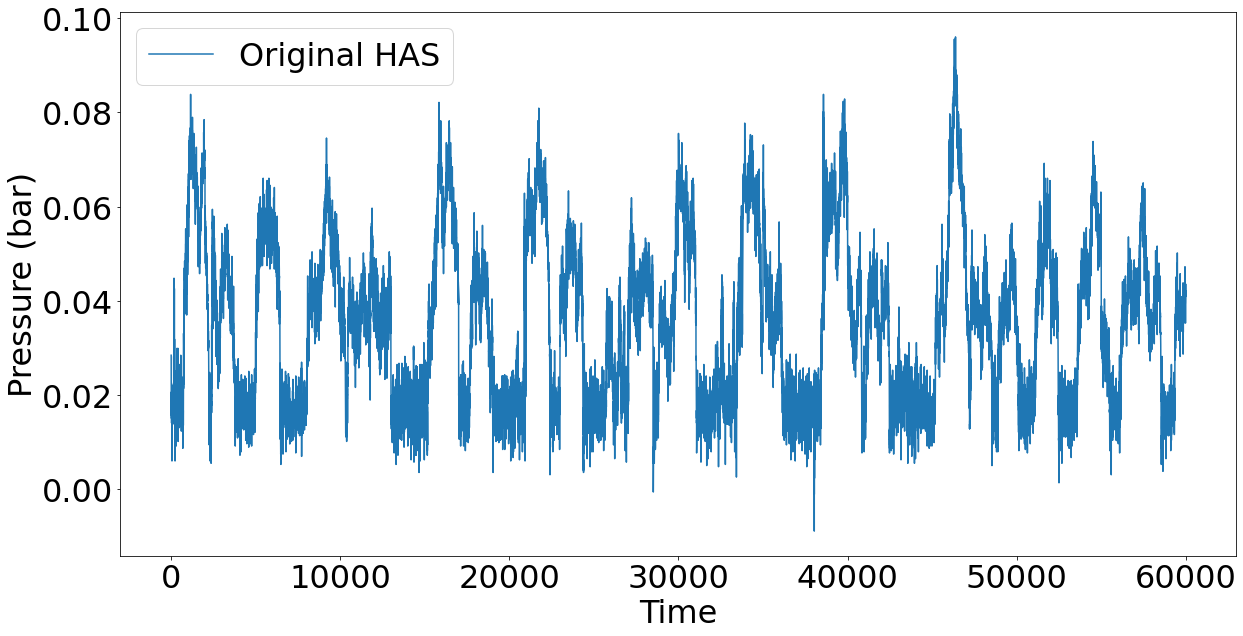

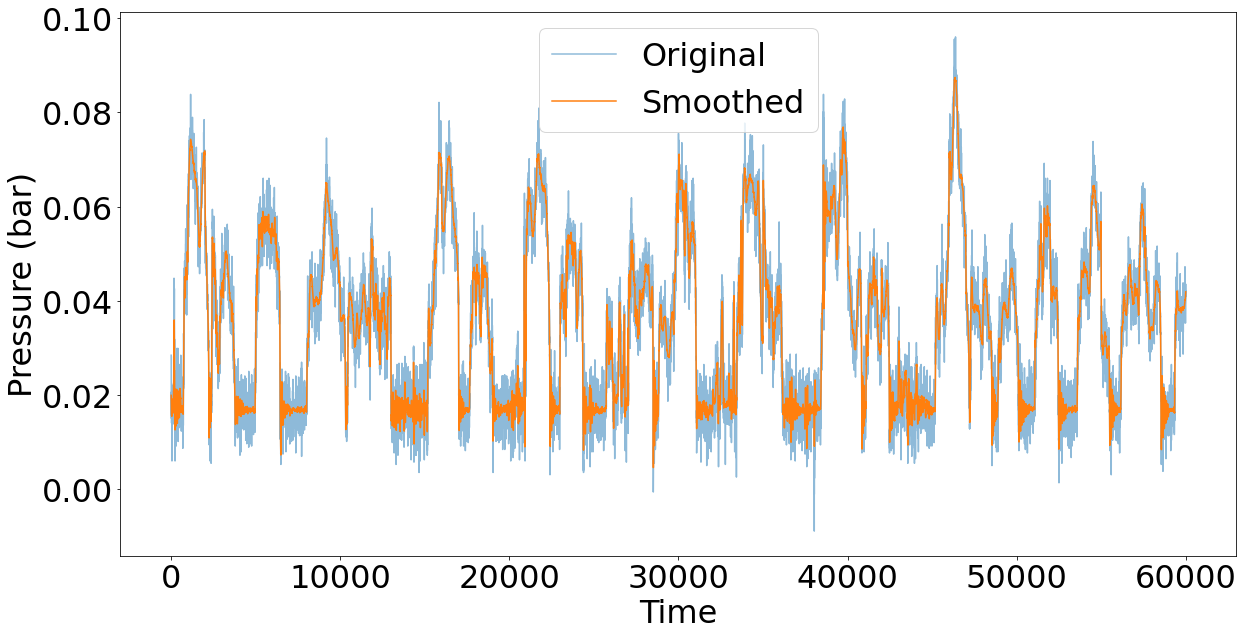

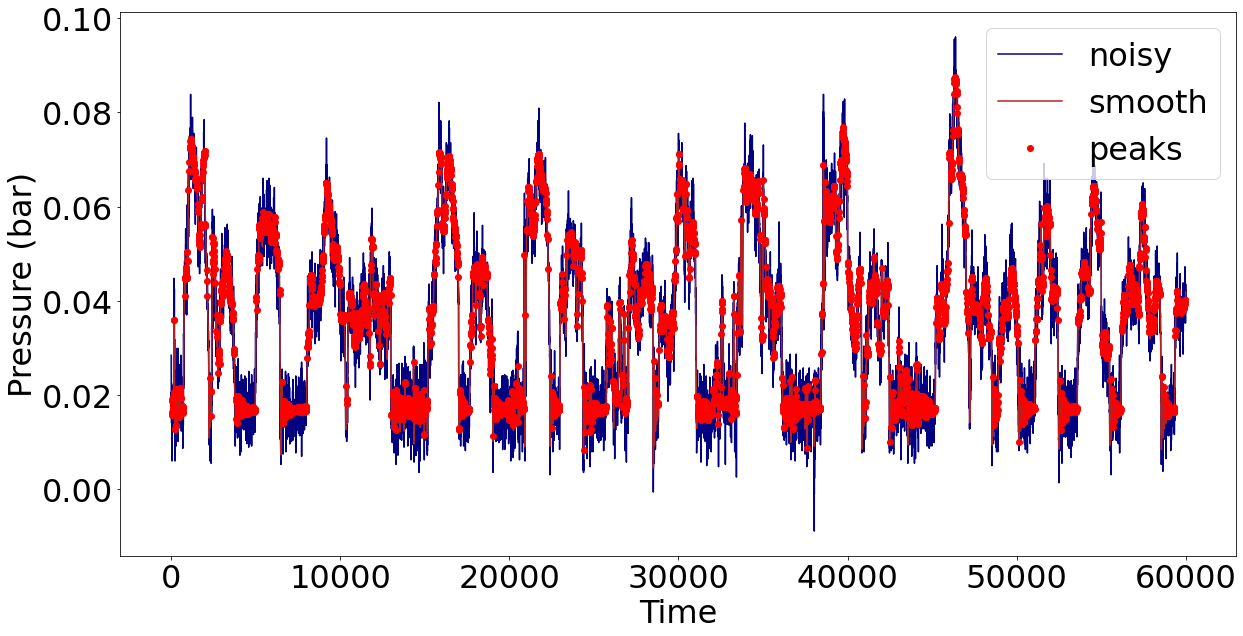

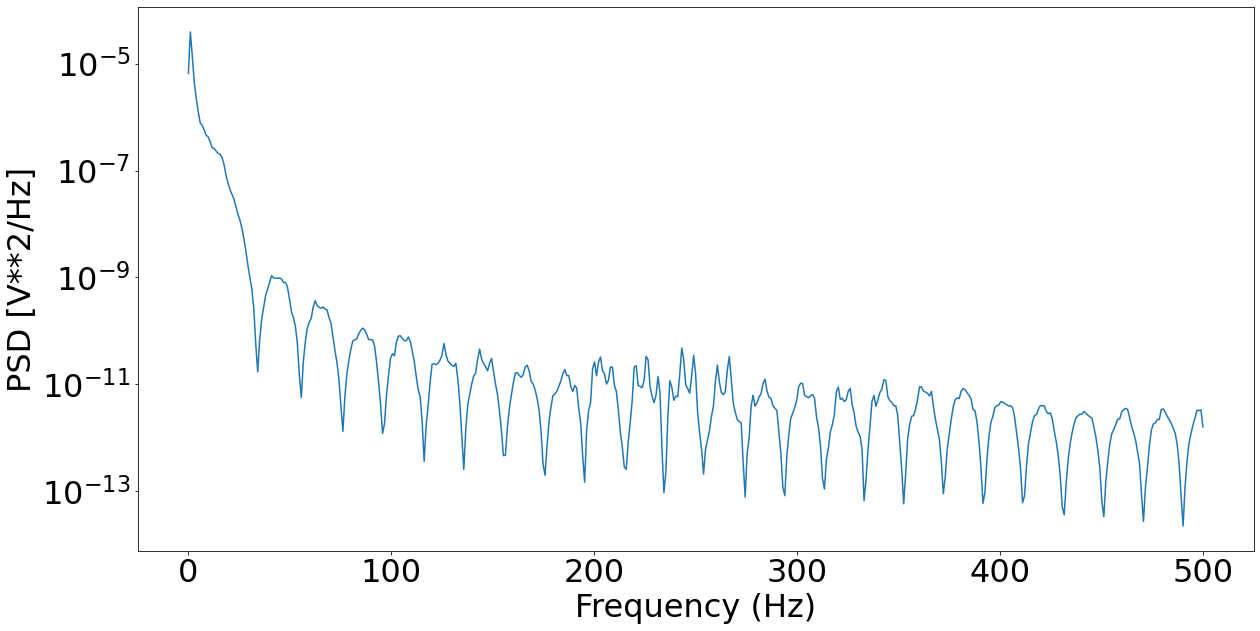

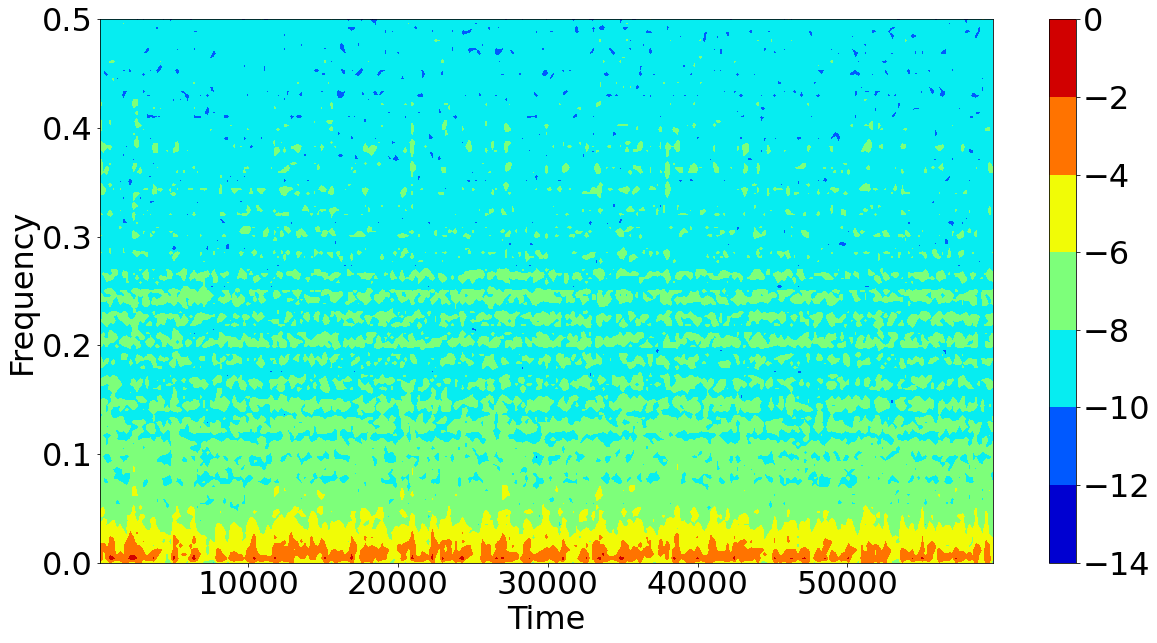

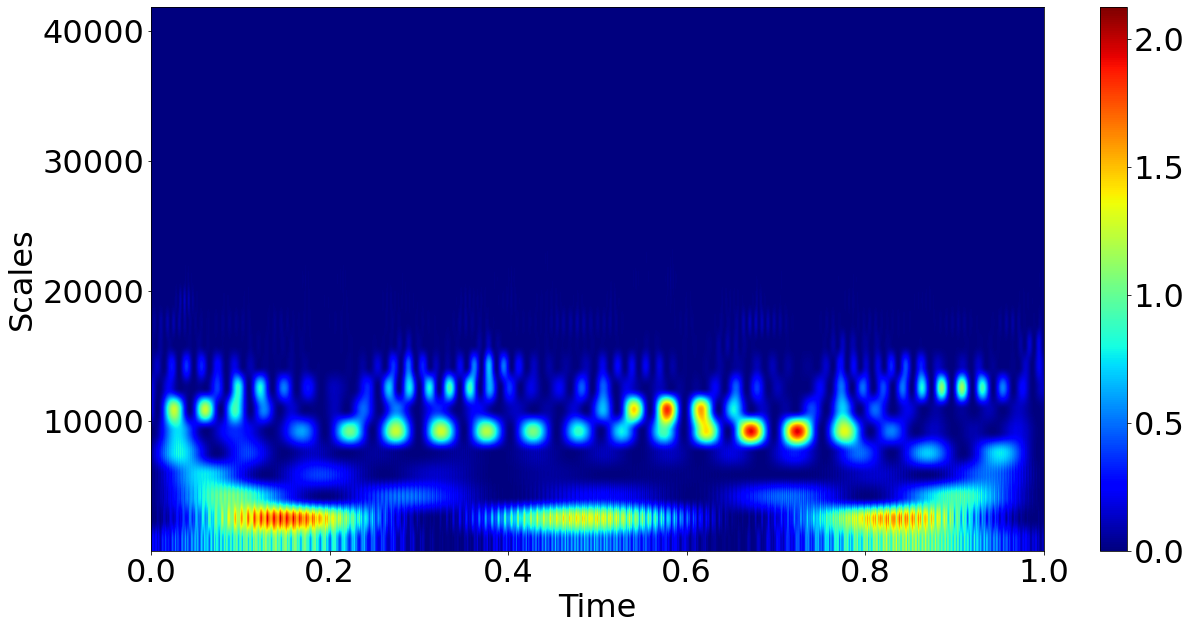

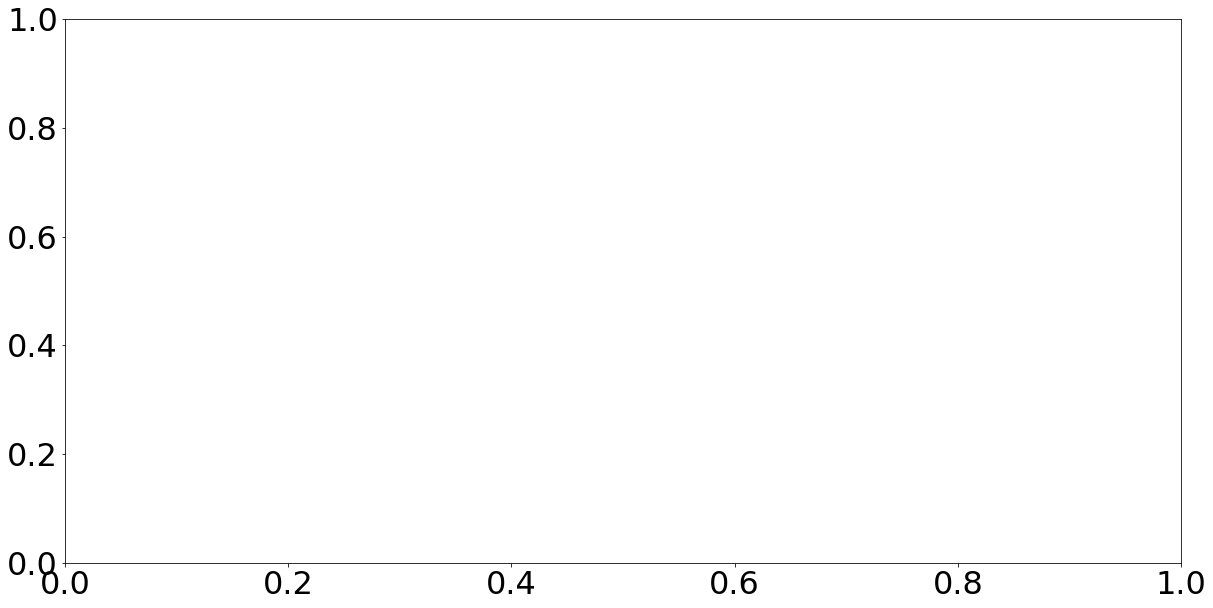

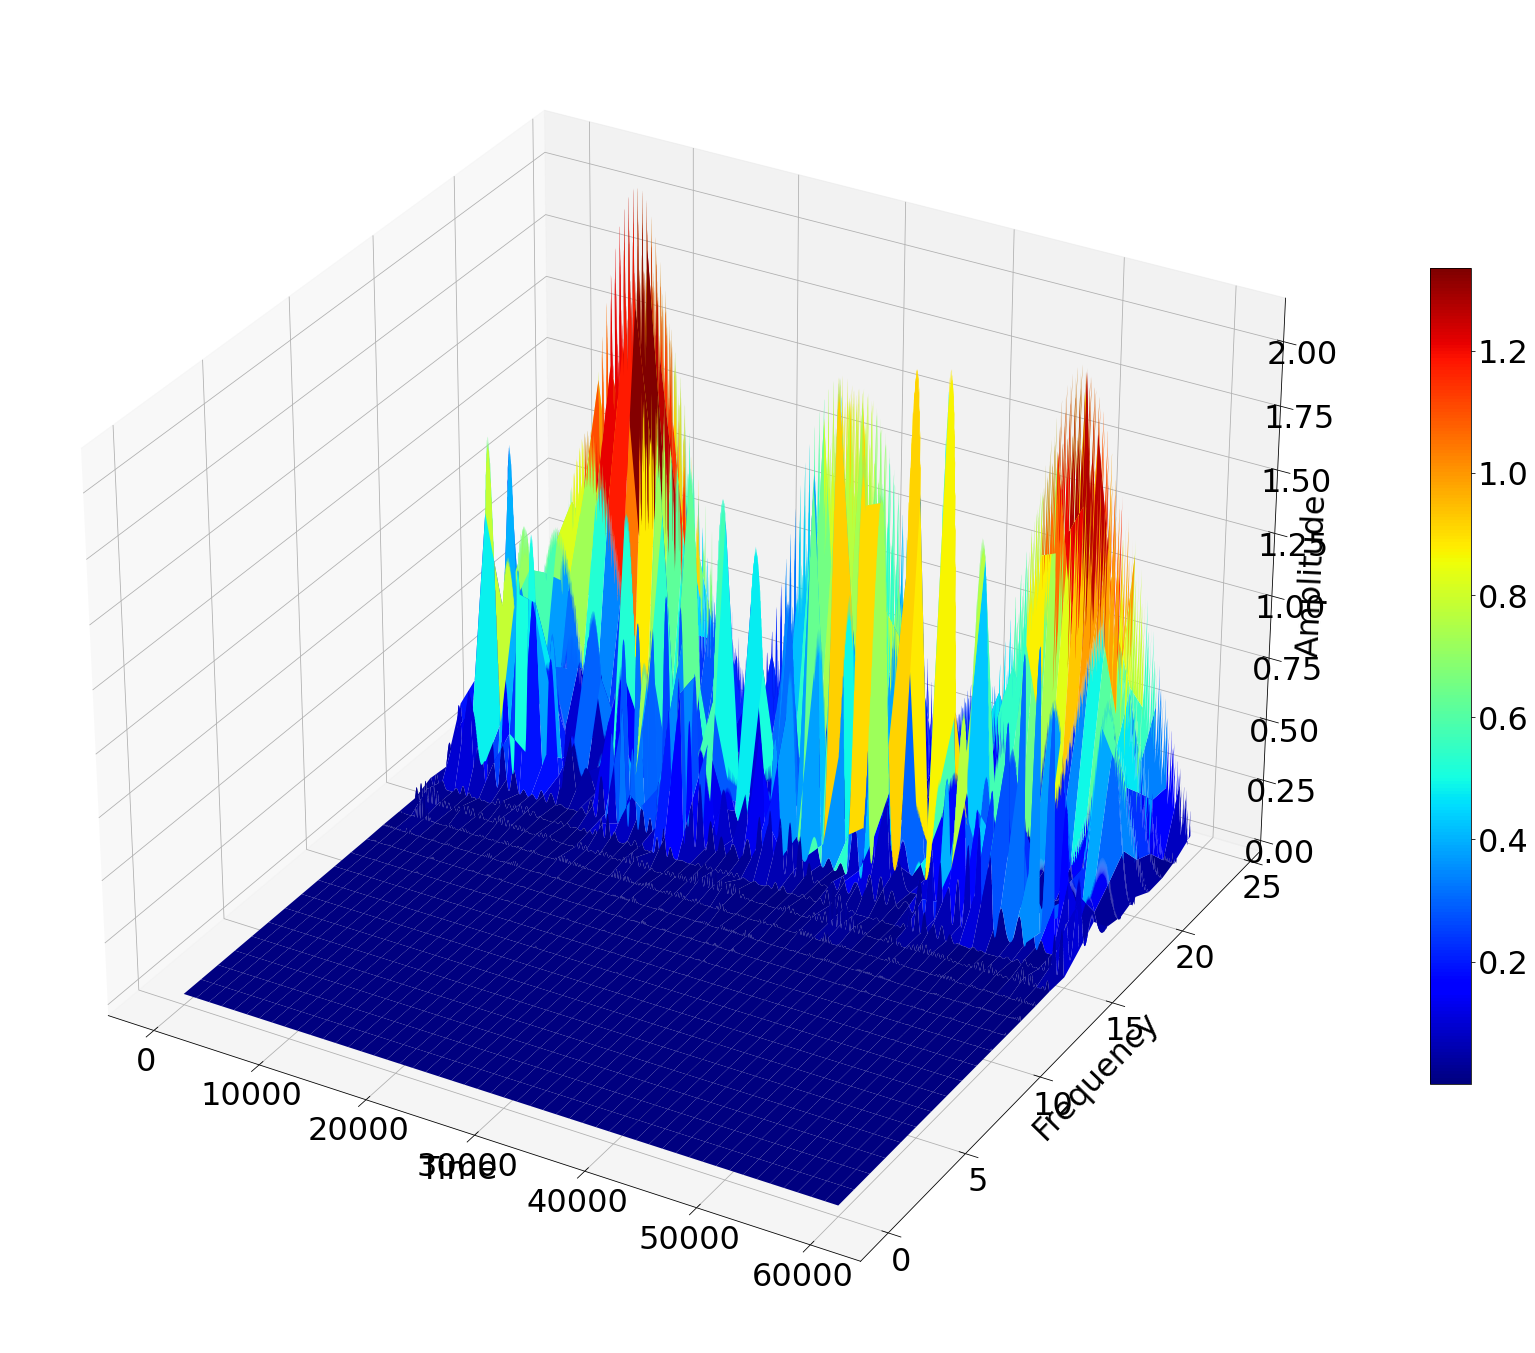


LAS
 


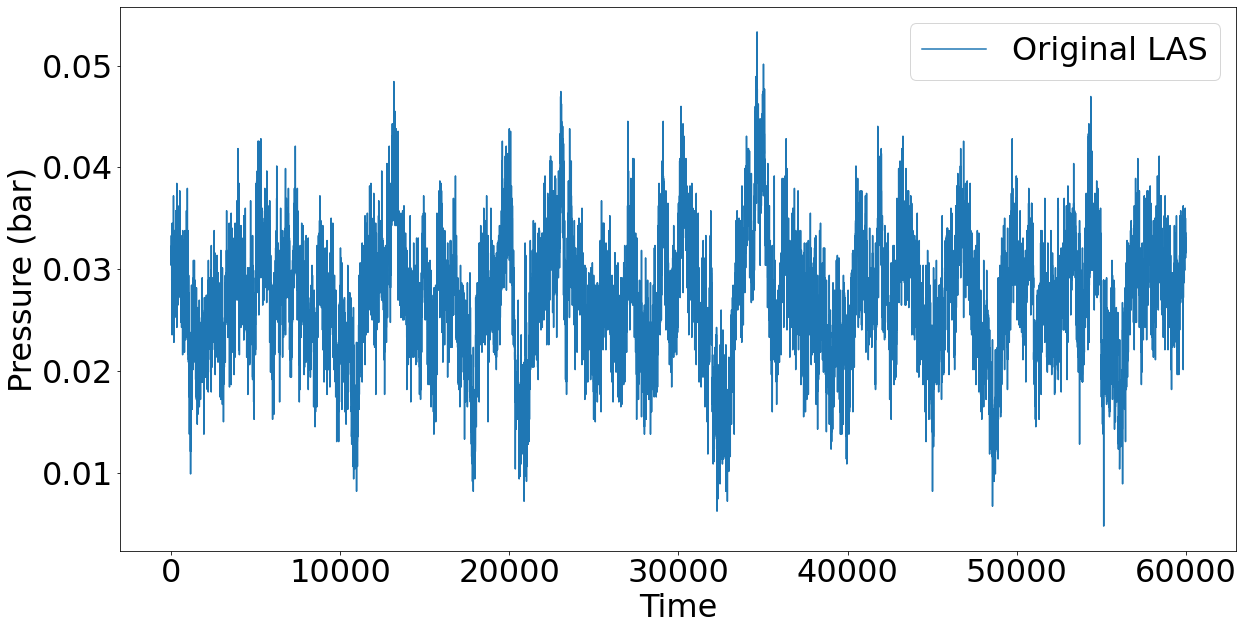

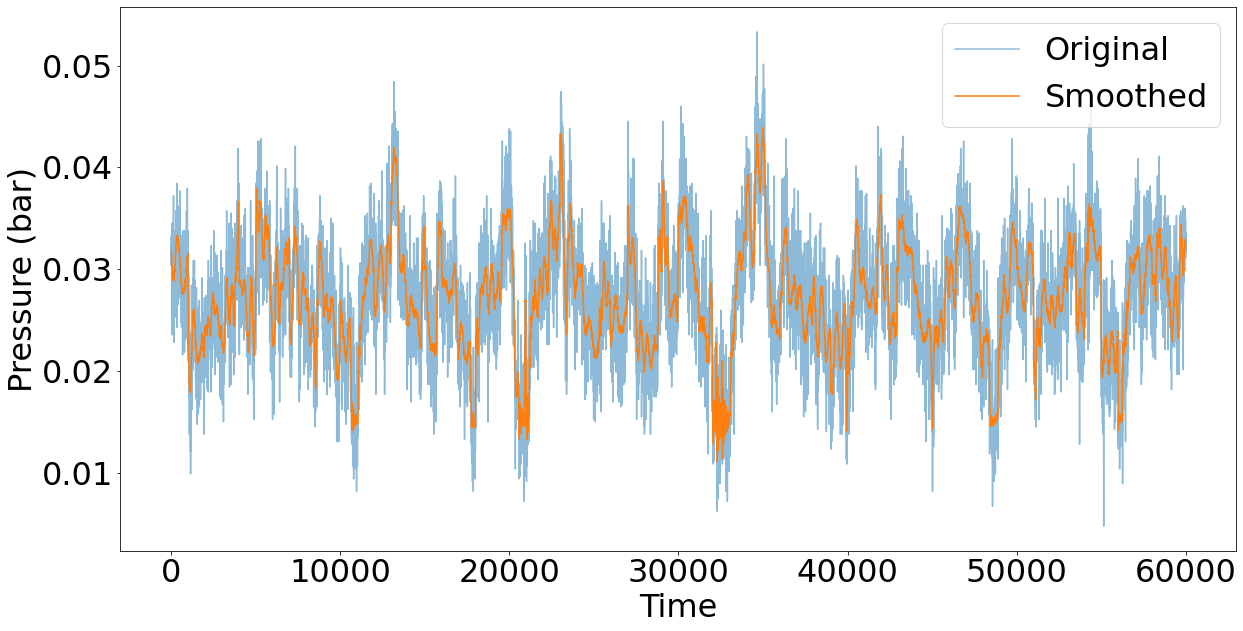

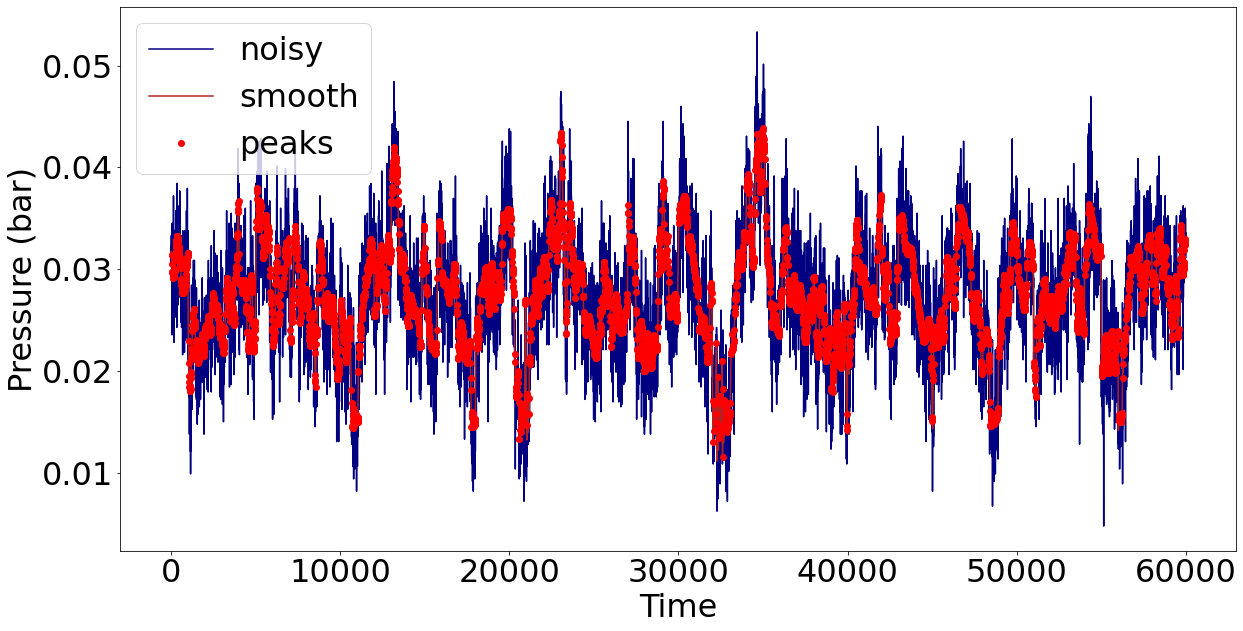

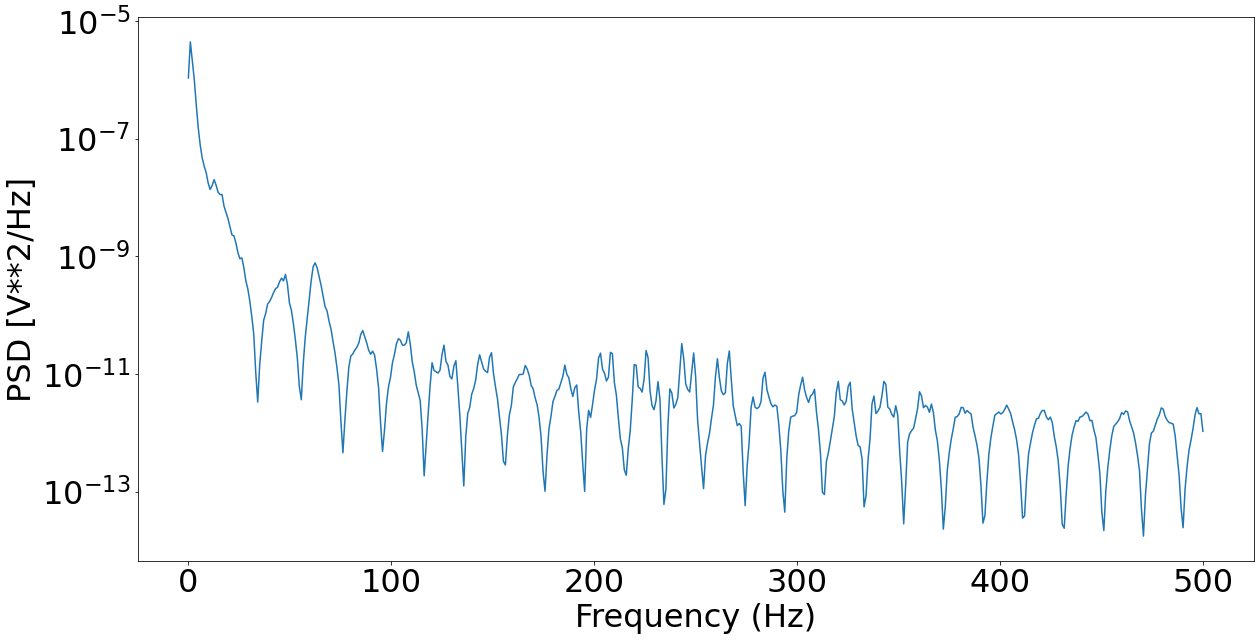

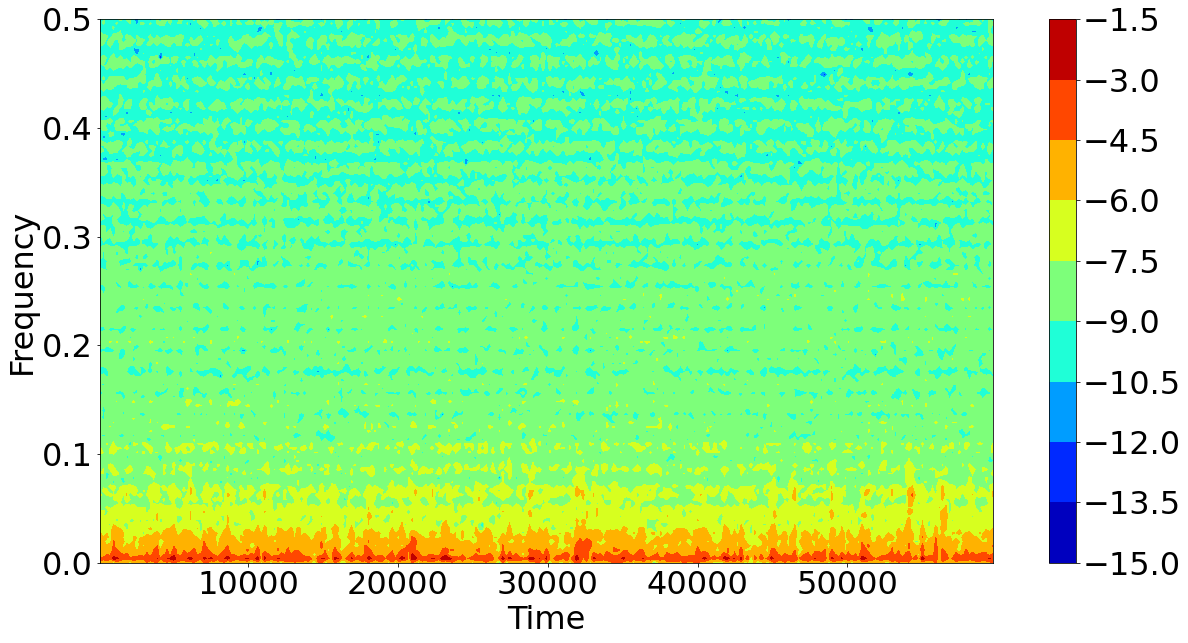

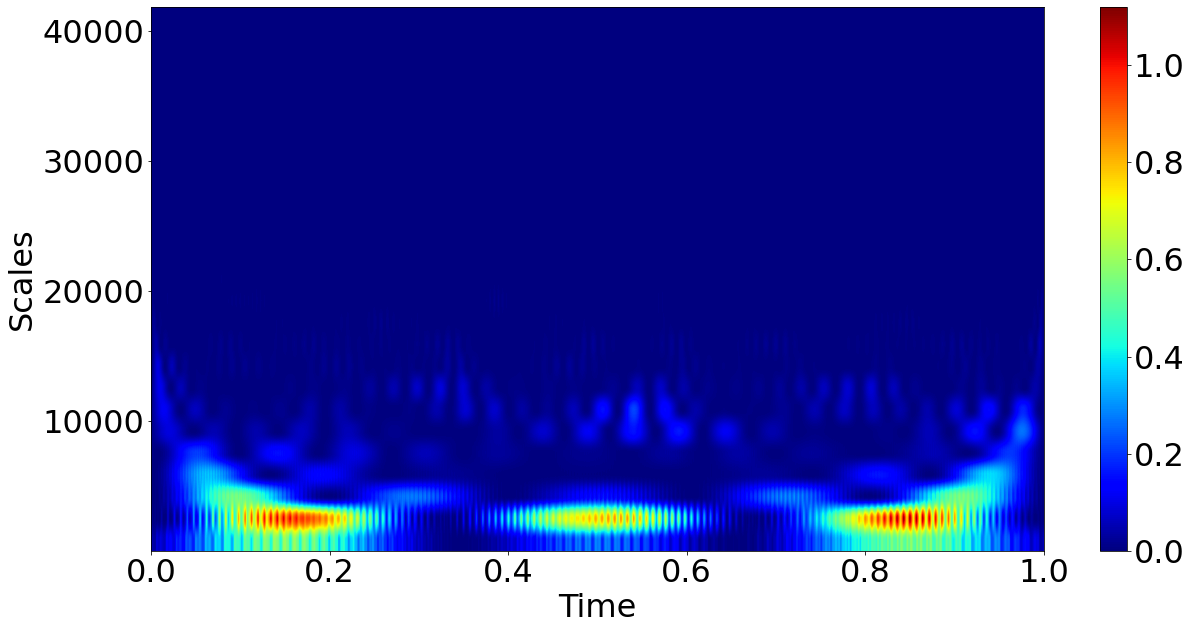

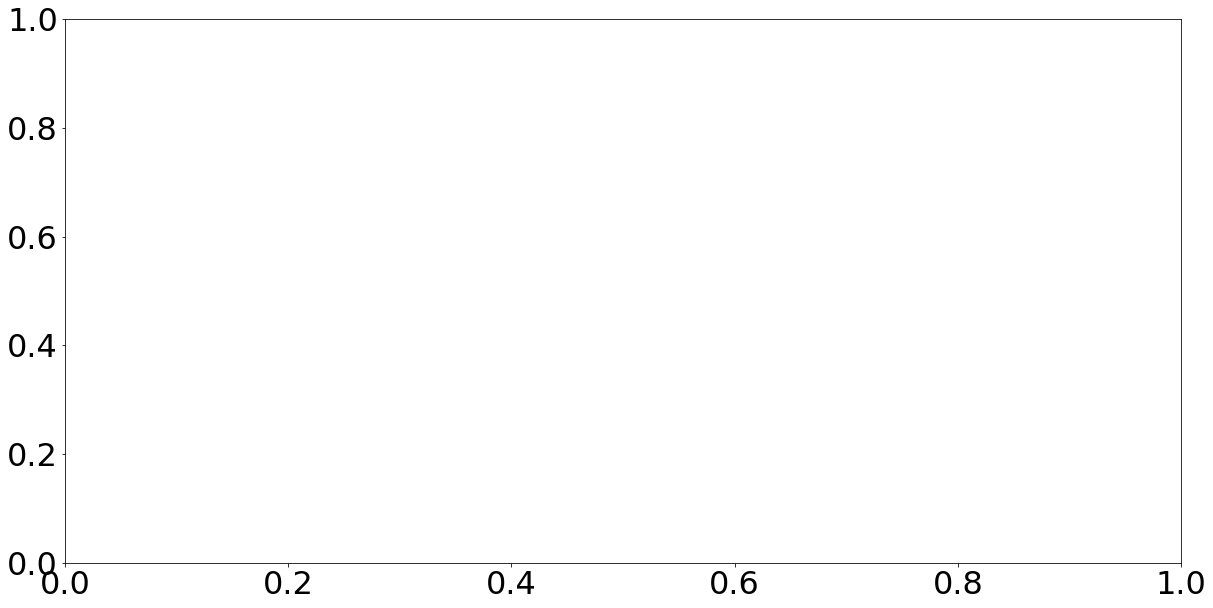

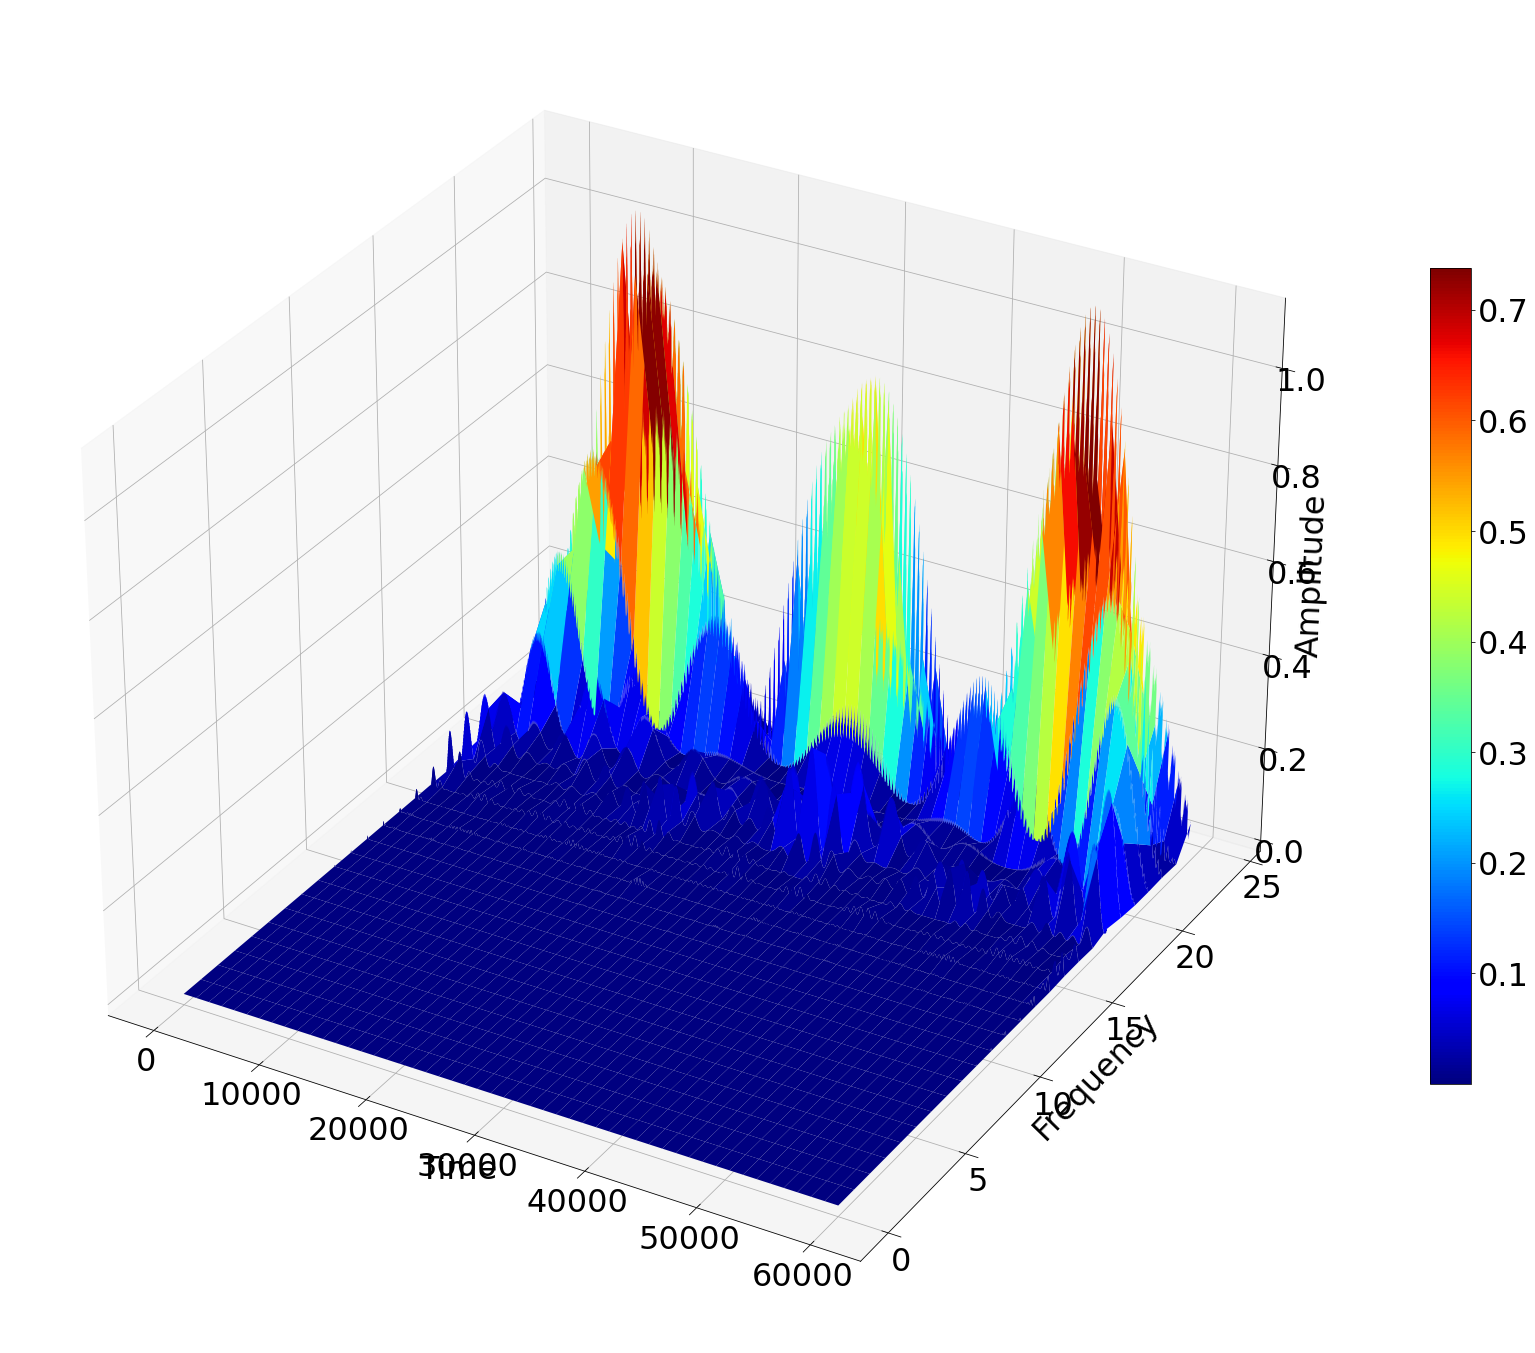


Plug
 


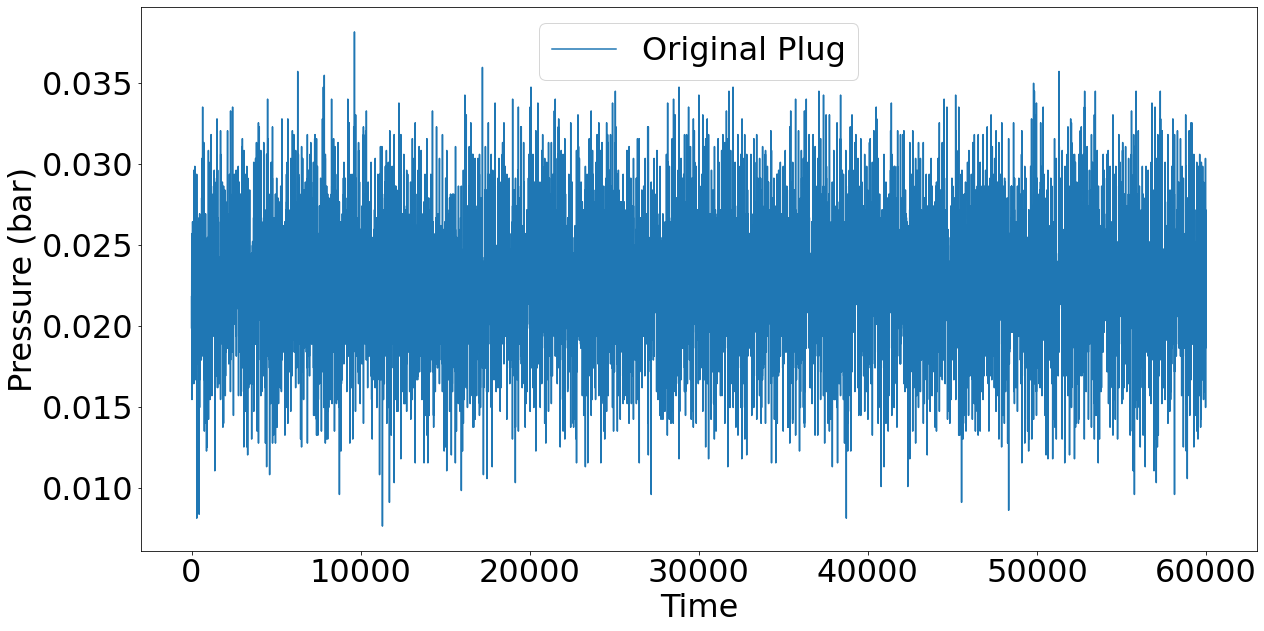

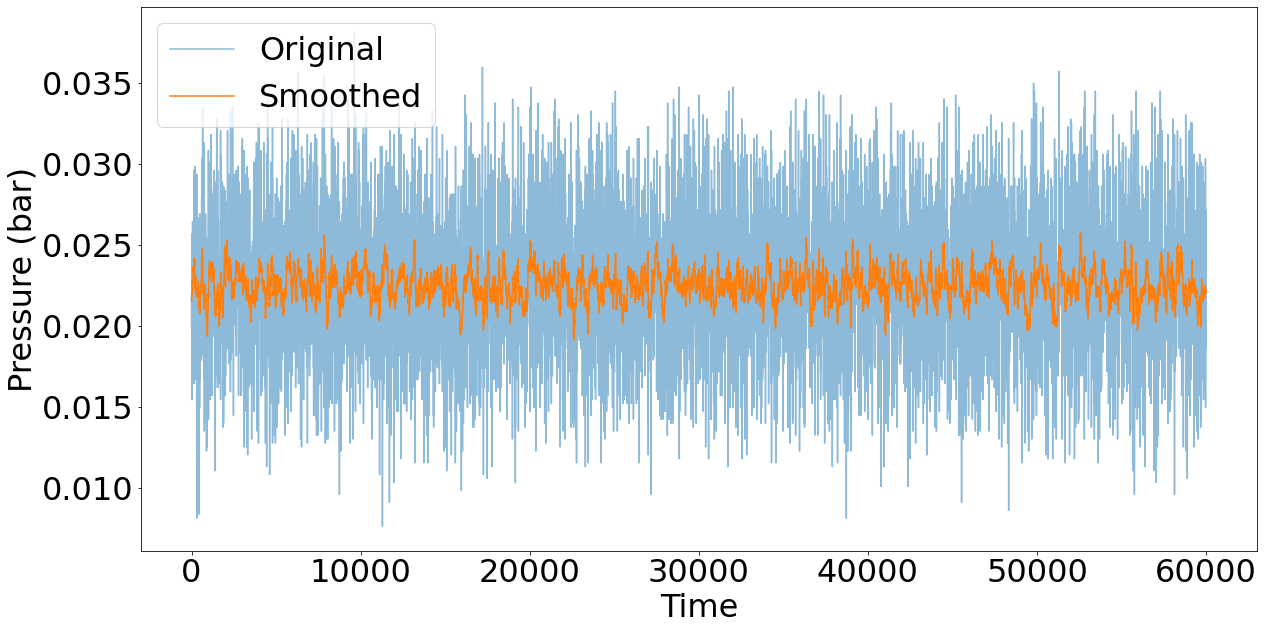

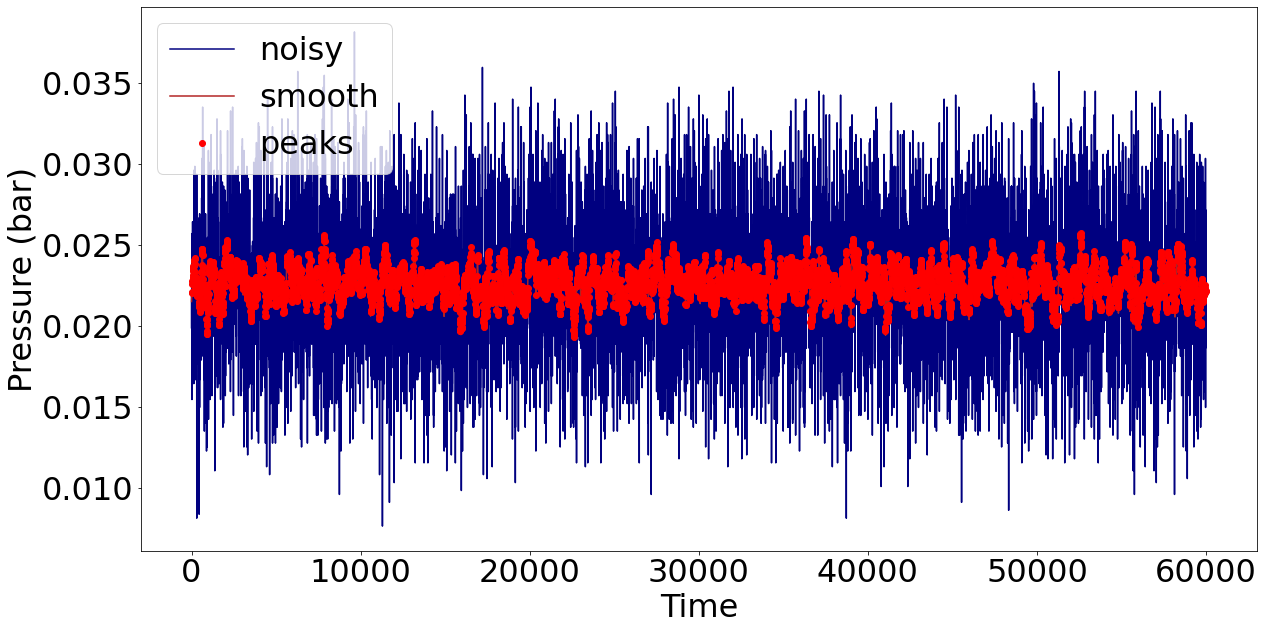

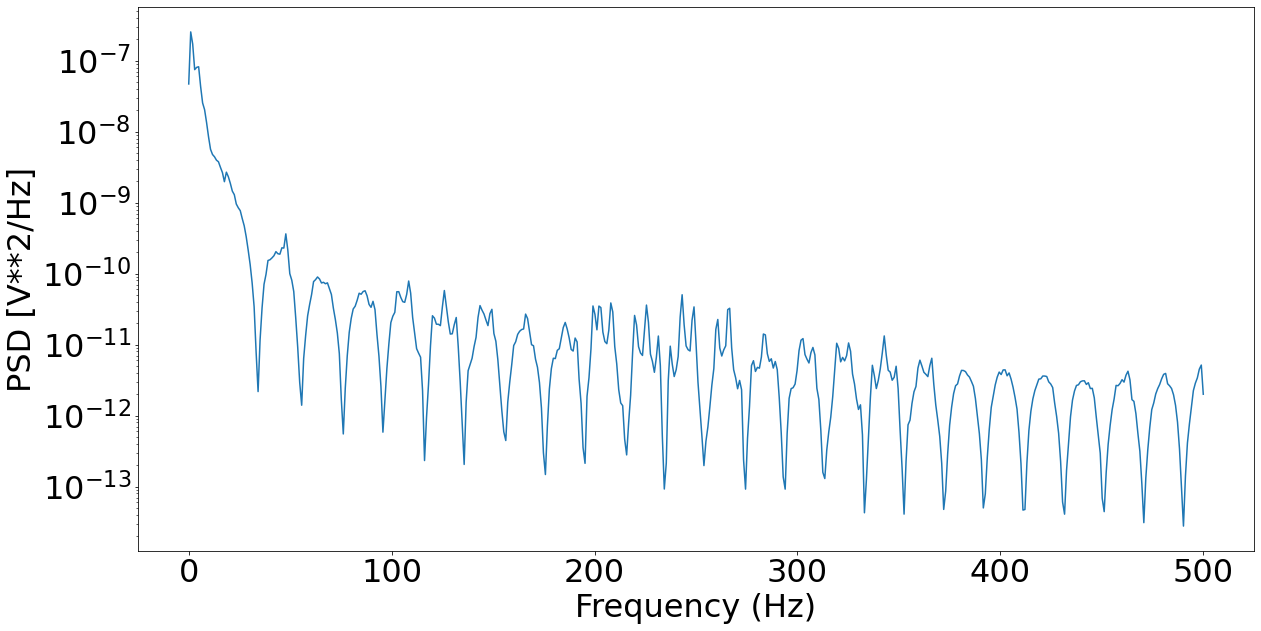

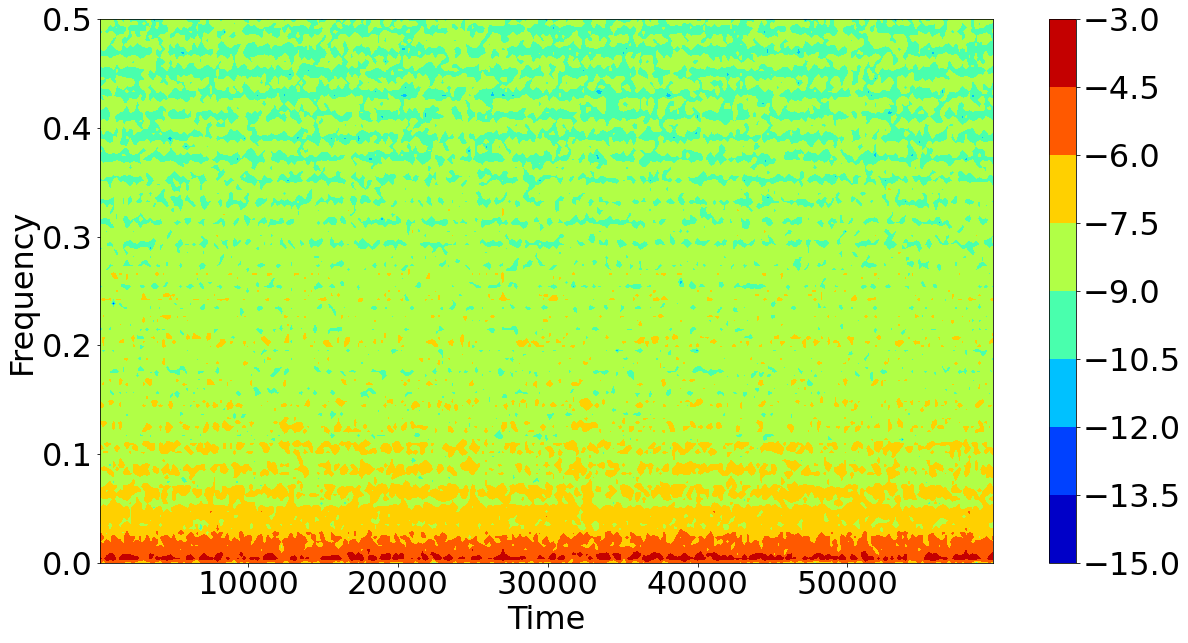

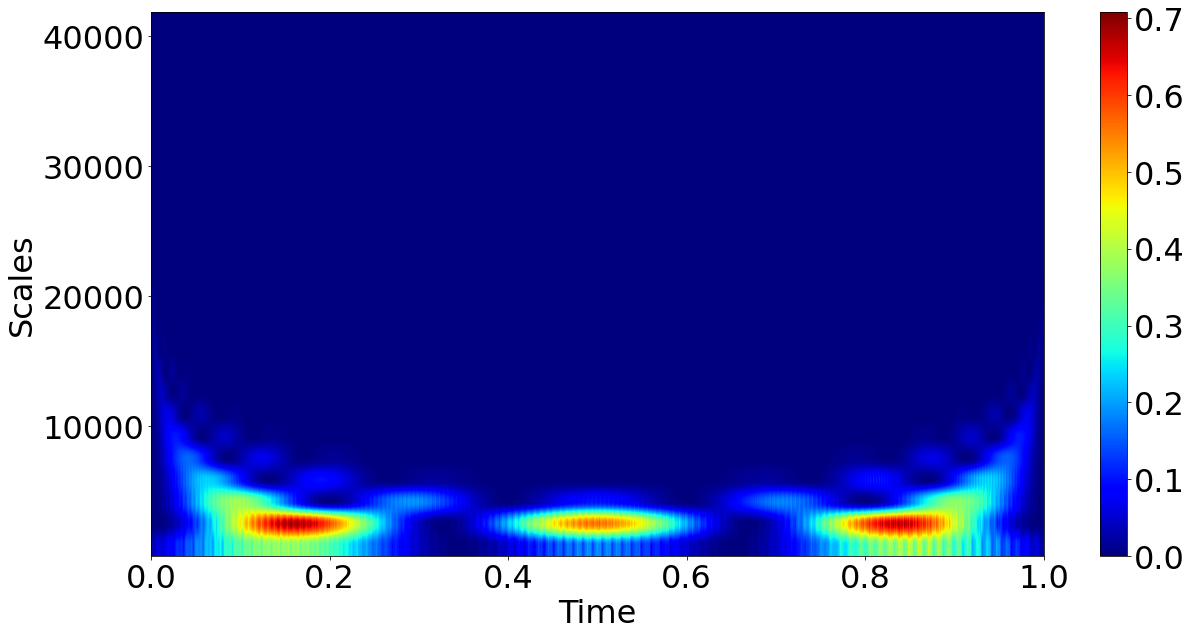

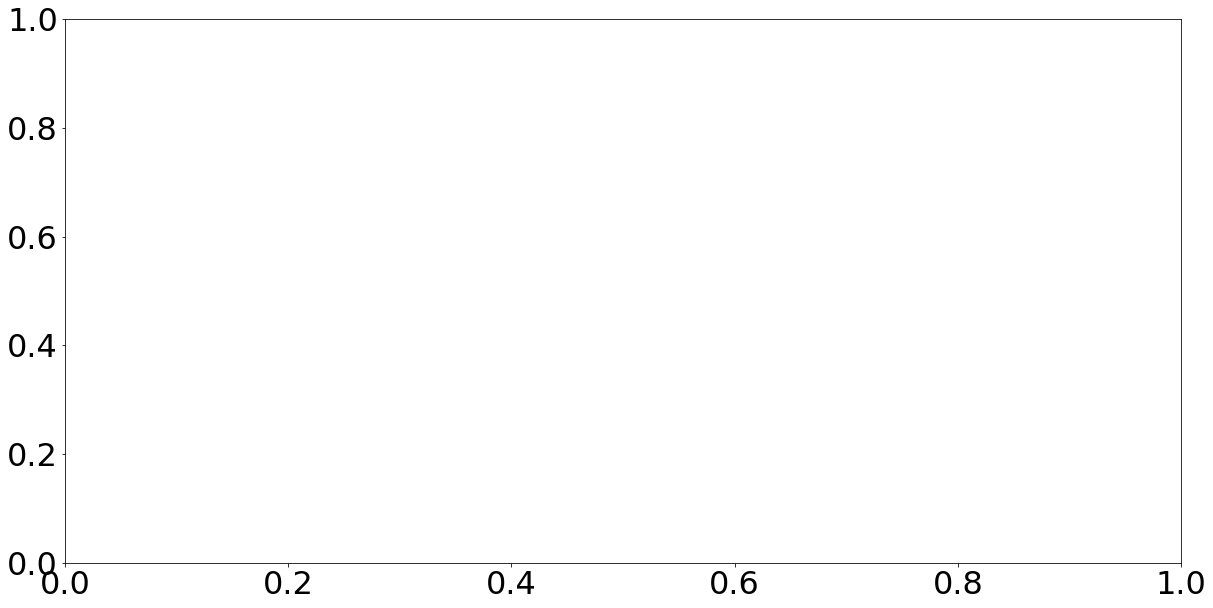

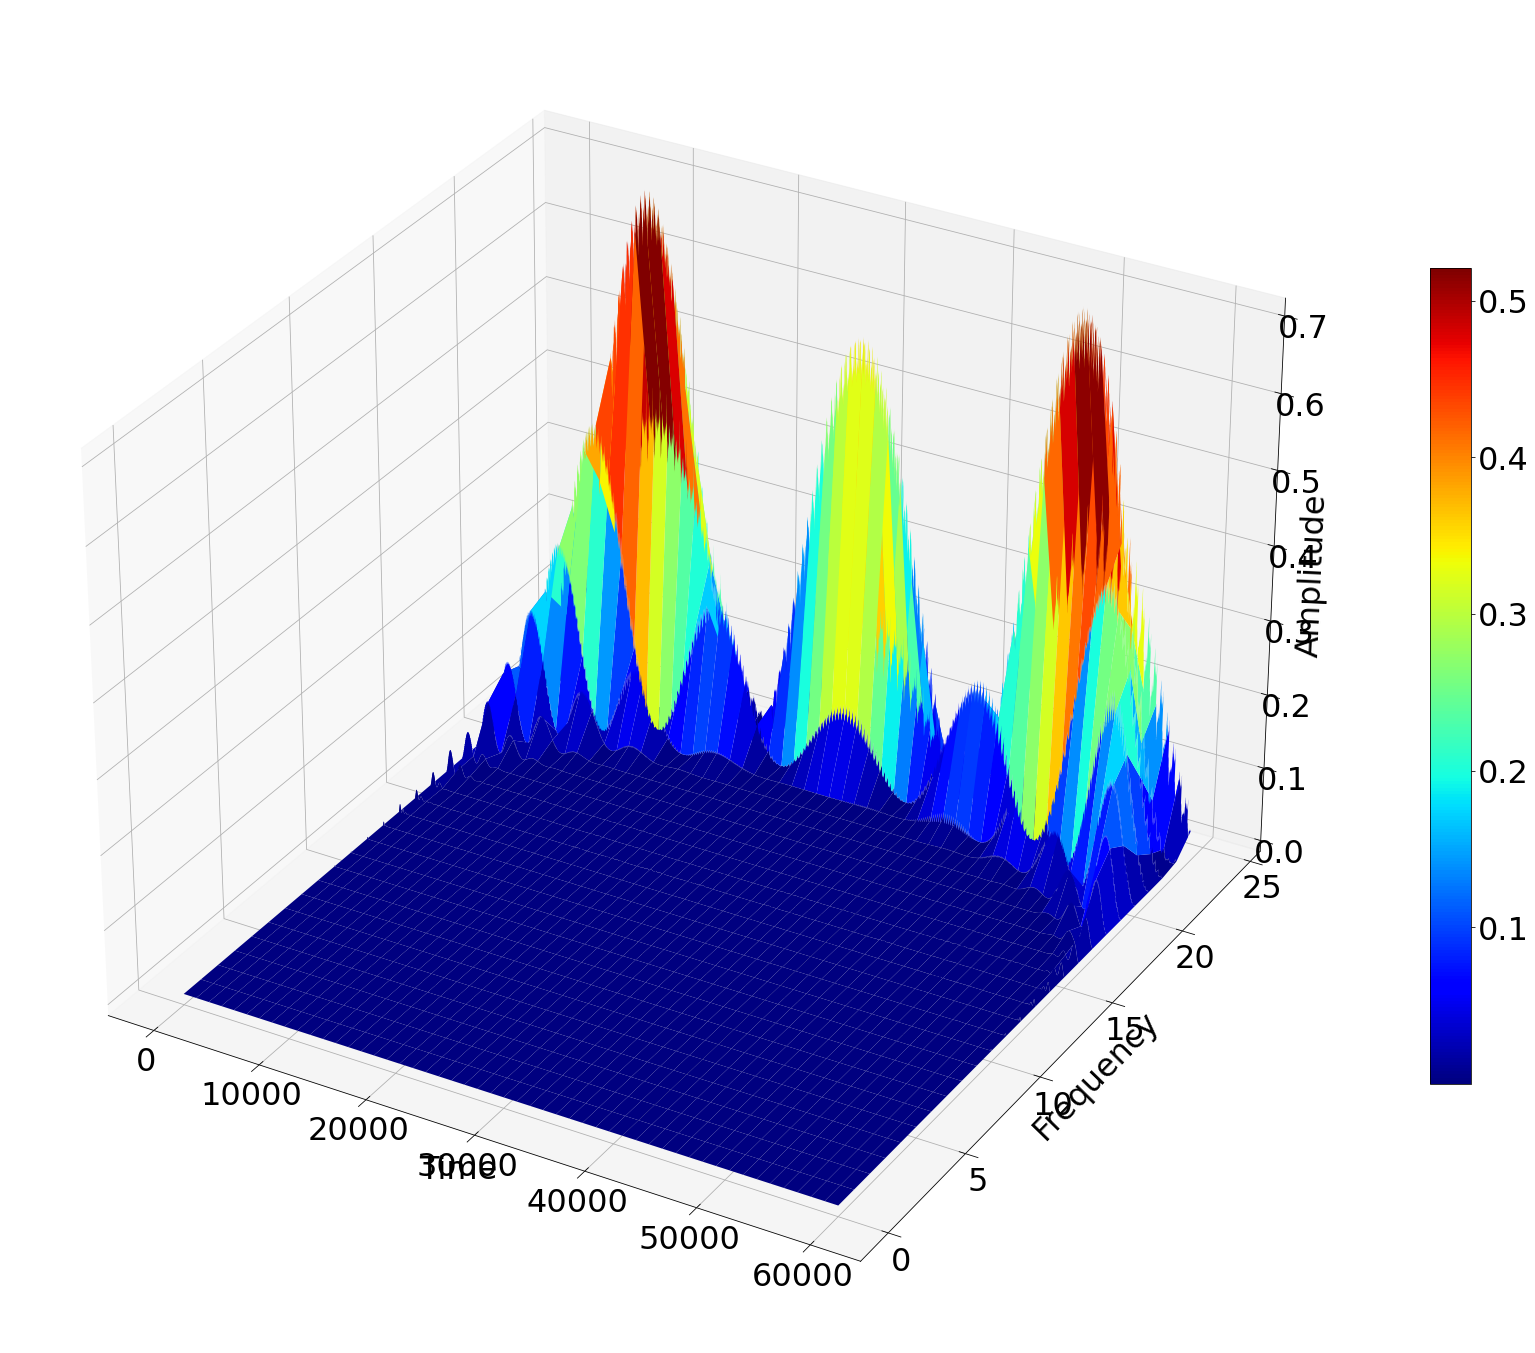

Temporal Features:
+--------+----------------+---------------+-----------+-----------+
| Signal | Mean Amplitude | Std Deviation |  Skewness |  Kurtosis |
+--------+----------------+---------------+-----------+-----------+
|  HAS   |    0.034975    |    0.016948   |  0.453108 | -0.790045 |
|  LAS   |    0.027169    |    0.005193   | -0.067315 |  0.320467 |
|  Plug  |    0.02253     |    0.000968   | -0.005786 |  0.063811 |
+--------+----------------+---------------+-----------+-----------+

Spectral Features:
+--------+---------------+-------------------+-----------------+
| Signal | Max Frequency | Spectral Centroid | Spectral Spread |
+--------+---------------+-------------------+-----------------+
|  HAS   |    0.976562   |      2.032542     |     3.240393    |
|  LAS   |    0.976562   |      1.889714     |     4.252481    |
|  Plug  |    0.976562   |      4.477778     |    14.537856    |
+--------+---------------+-------------------+-----------------+


In [73]:
analyze_and_plot_signals(ns_signals=[HAS_5_600_sen4,LAS_3_600_sen4,Plug_1_600_sen4],sig_names=['HAS','LAS','Plug'],t=time)